# Analyzing Government Responses by Different Countries
In this project, we investigate similarities and differences in government responses to COVID-19 and how that may affect the infection rate.

We use data obtained from https://www.bsg.ox.ac.uk/research/research-projects/oxford-covid-19-government-response-tracker to identify the responses taken by governments at each date.

We obtain infection rate data from https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data.  We use the Jupyter Notebook available from https://github.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning to preprocess the data into a format suitable for our notebook.

We also include other features such as Hofstede's Cultural Dimensions and temperature for each country.

In [ ]:
import os
import pandas as pd
import numpy as np
import datetime
import re
import math
import scipy
import statsmodels.api as sm

import matplotlib.pyplot as plt
import datetime

from IPython.display import display 

import warnings
warnings.filterwarnings('ignore')

if not os.path.exists("./figures"):
    os.makedirs("./figures")

os.getcwd()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'/content'

We use the following <strong>global parameters</strong> in our experiment:

In [ ]:
# number of days to shift labels by
lag = 14

confirmed_threshold = 10        # only include dates with smoothed average confirmed cases of at least 10
seed = 3 # for randomization
date_range = ['2020-04-01', '2020-09-30']
oxcgrt_file = './data/OxCGRT_latest_20201101.csv'
covid19_file = './data/covid_19_clean_complete_20201101.csv'
hofstede_file = './data/6-dimensions-for-website-2015-08-16.xls'


# name of label to predict ('ConfirmedGrowth' or 'DailyGrowth')
label_name = "ConfirmedGrowth"
#label_name = "DailyGrowth"

# use sample balancing technique
use_smogn = False

# percentage of data to trim from both ends 
trim_pct = 0.025

# dataset split method (True = extrapolation, False = interpolation)
time_series_split_method = True

# prediction_factor threshold
p_factor_threshold = 0.005

# previous days shift (0 = include current date data, 1 = include data from yesterday)
prev_days = 0

# use cultural dimensions
use_cultural_dimensions = True

# percentage change between how many days
pct_change_days = 14

group_dates = False
num_days_threshold = 3

# features from the NPI dataset to include
features_to_include = ['C1_School closing', 'C1_Flag', 
                       'C2_Workplace closing', 'C2_Flag', 
                       'C3_Cancel public events', 'C3_Flag', 
                       'C4_Restrictions on gatherings', 'C4_Flag', 
                       'C5_Close public transport', 'C5_Flag', 
                       'C6_Stay at home requirements', 'C6_Flag', 
                       'C7_Restrictions on internal movement', 'C7_Flag', 
                       'C8_International travel controls', 
                       'E1_Income support', 'E1_Flag',
                       'E2_Debt/contract relief',
                       'H1_Public information campaigns', 'H1_Flag',
                       'H2_Testing policy', 'H3_Contact tracing',
                       'StringencyIndex',
                       'GovernmentResponseIndex',
                       'ContainmentHealthIndex',
                       'EconomicSupportIndex']

if label_name == 'ConfirmedGrowth':
  features_to_exclude = ['Daily', 'DailyGrowth', 'PrevDailyGrowth', 'PrevDaily'] #+['PrevConfirmed', 'PrevConfirmedGrowth']
else:
  features_to_exclude = ['Confirmed', 'ConfirmedGrowth', 'PrevConfirmedGrowth', 'PrevConfirmed']

tags = ['CountryName', 'CountryCode', 'Date']

run_models = {'LinearRegression': False,
             'LinearRegressionReg': False,
             'DecisionTree': False,
             'BagLinearRegression': False,
             'RandomForest': False,
             'SVR': False,
             'NeuralNetwork': False,
             'AdaBoost': True}

# feature selection
p_threshold = 0.05
mi_threshold = 0.1
both_thresholds = False
threshold_to_use = ['mutual_info']

times_new_roman = False


In [ ]:
"""
#!pip show matplotlib

#!sudo apt-get install msttcorefonts
!sudo apt-get install --reinstall ttf-mscorefonts-installer
!pip show msttcorefonts
#!cp usr/share/fonts/truetype/msttcorefonts/Times_New_Roman* usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
"""

if times_new_roman:
    # diagram parameters
    """
    import  matplotlib.font_manager
    flist = matplotlib.font_manager.get_fontconfig_fonts()
    names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
    print(names)
    """
    plt.rcParams["font.family"] = "Times New Roman"

Because some countries may have alternate names, we manually create a dictionary of paired names in the multiple datasets.  The key refers to the country name in `covid19_rates` or Hofstede's 6 Cultural Dimensions, whereas the value is the country name in `govt_responses`.

Our final DataFrame will use the names from `govt_responses`.

Here are some examples: https://online.seterra.com/en/p/multiple-names

In [ ]:
alternate_country_names = {"US": "United States", 
                           "U.S.A.": "United States",
                           "Taiwan*": "Taiwan", 
                           "North Macedonia": "Macedonia",
                           "Macau": "Macao",
                           "West Bank and Gaza": "Palestine",
                           "Burma": "Myanmar",
                           "Czechia": "Czech Republic",
                           "Czech Rep": "Czech Republic",
                           "Kyrgz Rep": "Kyrgyzstan",
                           "Slovak Rep": "Slovak Republic",
                           "Timor-Leste": "Timor",
                           "Eswatini": "Swaziland",
                           "Dominican Rep": "Dominican Republic"
                          }

## Loading the Dataset

We first import the data from these two websites and load them into Pandas DataFrames, with keys as the countries and the dates.

### NPI Dataset

In [ ]:
govt_responses = pd.read_csv(oxcgrt_file)

# remove garbage column
if "Unnamed: 39" in govt_responses.columns:
    govt_responses = govt_responses.drop(columns=["Unnamed: 39", "StringencyIndexForDisplay"])

govt_responses

,CountryName,CountryCode,RegionName,RegionCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,NaN,NaN,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
1,Aruba,ABW,NaN,NaN,20200102,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
2,Aruba,ABW,NaN,NaN,20200103,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
3,Aruba,ABW,NaN,NaN,20200104,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
4,Aruba,ABW,NaN,NaN,20200105,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74353,Zimbabwe,ZWE,NaN,NaN,20201028,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,3.0,1.0,NaN,8315.0,242.0,71.3,71.3,77.38,77.38,60.71,60.71,66.67,66.67,25.0,25.0
74354,Zimbabwe,ZWE,NaN,NaN,20201029,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,3.0,1.0,NaN,8320.0,242.0,71.3,71.3,77.38,77.38,60.71,60.71,66.67,66.67,25.0,25.0
74355,Zimbabwe,ZWE,NaN,NaN,20201030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8349.0,242.0,NaN,71.3,NaN,77.38,NaN,60.71,NaN,66.67,NaN,25.0
74356,Zimbabwe,ZWE,NaN,NaN,20201031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8362.0,242.0,NaN,71.3,NaN,77.38,NaN,60.71,NaN,66.67,NaN,25.0


Some versions of the NPI dataset contains a column called "RegionName".  Because we are only interested in countries, we remove all rows which are specific to a certain region.

In [ ]:
if "RegionName" in govt_responses:
  # remove rows where Region is specified
  govt_responses = govt_responses[govt_responses['RegionName'].isnull()]
  # remove RegionName
  govt_responses = govt_responses.drop(columns=["RegionName"])
  # renumber index
  govt_responses = govt_responses.reset_index()
  govt_responses.drop(columns=["index"])
display(govt_responses[govt_responses['CountryName'] == 'Canada'])

,index,CountryName,CountryCode,RegionCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
8874,8874,Canada,CAN,NaN,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,3.57,3.57,4.17,4.17,0.0,0.0
8875,8875,Canada,CAN,NaN,20200102,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,3.57,3.57,4.17,4.17,0.0,0.0
8876,8876,Canada,CAN,NaN,20200103,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,3.57,3.57,4.17,4.17,0.0,0.0
8877,8877,Canada,CAN,NaN,20200104,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,3.57,3.57,4.17,4.17,0.0,0.0
8878,8878,Canada,CAN,NaN,20200105,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.00,0.00,0.00,0.00,3.57,3.57,4.17,4.17,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9175,9175,Canada,CAN,NaN,20201028,2.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,0.0,NaN,222887.0,10001.0,60.65,60.65,60.24,60.24,68.45,68.45,67.36,67.36,75.0,75.0
9176,9176,Canada,CAN,NaN,20201029,2.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,0.0,NaN,225586.0,10032.0,60.65,60.65,60.24,60.24,68.45,68.45,67.36,67.36,75.0,75.0
9177,9177,Canada,CAN,NaN,20201030,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228542.0,10074.0,NaN,60.65,NaN,60.24,NaN,68.45,NaN,67.36,NaN,75.0
9178,9178,Canada,CAN,NaN,20201031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231999.0,10110.0,NaN,60.65,NaN,60.24,NaN,68.45,NaN,67.36,NaN,75.0


### COVID-19 Infection Numbers Dataset

In [ ]:
covid19_rates = pd.read_csv(covid19_file)
covid19_rates

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
74687,NaN,West Bank and Gaza,31.952200,35.233200,2020-10-31,53520,483,46309,6728,Eastern Mediterranean
74688,NaN,Western Sahara,24.215500,-12.885800,2020-10-31,10,1,8,1,Africa
74689,NaN,Yemen,15.552727,48.516388,2020-10-31,2063,599,0,1464,Eastern Mediterranean
74690,NaN,Zambia,-13.133897,27.849332,2020-10-31,16432,349,15680,403,Africa


Because some countries may have alternate names, we manually create a dictionary of paired names in the two datasets.  The key refers to the country name in `covid19_rates`, whereas the value is the country name in `govt_responses`.

Here are some examples: https://online.seterra.com/en/p/multiple-names

In [ ]:
covid19_rates = covid19_rates.replace(alternate_country_names)
covid19_rates.loc[covid19_rates['Country/Region'] == "United States"]

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
239,NaN,United States,40.0,-100.0,2020-01-22,1,0,0,1,Americas
502,NaN,United States,40.0,-100.0,2020-01-23,1,0,0,1,Americas
765,NaN,United States,40.0,-100.0,2020-01-24,2,0,0,2,Americas
1028,NaN,United States,40.0,-100.0,2020-01-25,2,0,0,2,Americas
1291,NaN,United States,40.0,-100.0,2020-01-26,5,0,0,5,Americas
...,...,...,...,...,...,...,...,...,...,...
73616,NaN,United States,40.0,-100.0,2020-10-27,8778055,226696,3487666,5063693,Americas
73879,NaN,United States,40.0,-100.0,2020-10-28,8856413,227685,3518140,5110588,Americas
74142,NaN,United States,40.0,-100.0,2020-10-29,8944934,228656,3554336,5161942,Americas
74405,NaN,United States,40.0,-100.0,2020-10-30,9044255,229686,3578452,5236117,Americas


In [ ]:
covid19_rates[covid19_rates['Country/Region'] == 'China']

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
54,Anhui,China,31.8257,117.2264,2020-01-22,1,0,0,1,Western Pacific
55,Beijing,China,40.1824,116.4142,2020-01-22,14,0,0,14,Western Pacific
56,Chongqing,China,30.0572,107.8740,2020-01-22,6,0,0,6,Western Pacific
57,Fujian,China,26.0789,117.9874,2020-01-22,1,0,0,1,Western Pacific
58,Gansu,China,35.7518,104.2861,2020-01-22,0,0,0,0,Western Pacific
...,...,...,...,...,...,...,...,...,...,...
74511,Tianjin,China,39.3054,117.3230,2020-10-31,270,3,251,16,Western Pacific
74512,Tibet,China,31.6927,88.0924,2020-10-31,1,0,1,0,Western Pacific
74513,Xinjiang,China,41.1129,85.2401,2020-10-31,956,3,899,54,Western Pacific
74514,Yunnan,China,24.9740,101.4870,2020-10-31,213,2,0,211,Western Pacific


Because the infection rate dataset contains provincial/regional level data for some countries, we need to sum the total for each country.  For convention, we use the NPI dataset's list of countries.  Any provinces in the infection rate dataset and listed as a country in the NPI dataset will be considered a country.

In [ ]:
# find indices in govt_responses where the CountryName is same as Province/State in covid19_rates
matching_idx = govt_responses.index[govt_responses['CountryName'].isin(covid19_rates['Province/State']) == True].to_list()

# get list of countries in govt_responses which are listed as Province/State in covid19_rates
matching_countries = list(govt_responses['CountryName'].iloc[matching_idx].unique())
display(matching_countries)

# move these provinces to countries
for country in matching_countries:
    row = covid19_rates.index[covid19_rates['Province/State'] == country]
    covid19_rates.iloc[row, covid19_rates.columns.get_loc('Country/Region')] = country

covid19_rates.loc[covid19_rates['Country/Region'] == "Hong Kong"]

['Aruba',
 'Anguilla',
 'Bermuda',
 'Cayman Islands',
 'Gibraltar',
 'Greenland',
 'Hong Kong',
 'Macao',
 'Montserrat',
 'Turks and Caicos Islands',
 'British Virgin Islands']

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
66,Hong Kong,Hong Kong,22.3,114.2,2020-01-22,0,0,0,0,Western Pacific
329,Hong Kong,Hong Kong,22.3,114.2,2020-01-23,2,0,0,2,Western Pacific
592,Hong Kong,Hong Kong,22.3,114.2,2020-01-24,2,0,0,2,Western Pacific
855,Hong Kong,Hong Kong,22.3,114.2,2020-01-25,5,0,0,5,Western Pacific
1118,Hong Kong,Hong Kong,22.3,114.2,2020-01-26,8,0,0,8,Western Pacific
...,...,...,...,...,...,...,...,...,...,...
73443,Hong Kong,Hong Kong,22.3,114.2,2020-10-27,5308,105,5053,150,Western Pacific
73706,Hong Kong,Hong Kong,22.3,114.2,2020-10-28,5310,105,5063,142,Western Pacific
73969,Hong Kong,Hong Kong,22.3,114.2,2020-10-29,5313,105,5073,135,Western Pacific
74232,Hong Kong,Hong Kong,22.3,114.2,2020-10-30,5320,105,5082,133,Western Pacific


We now format the date string in `covid19_rates` to match that of `govt_responses`.

In [ ]:
# convert DD/MM/YY to datetime64 format
covid19_rates['Date'] = covid19_rates['Date'].astype('datetime64[ns]') 

# convert YYMMDD to datetime64 format
govt_responses['Date'] = pd.to_datetime(govt_responses['Date'], format="%Y%m%d")

Because `govt_responses` only contains countries, we now sum all the province-level entries with the same 'Country/Region' and 'Date' in `covid19_rates`.  (See https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/README.md)

In [ ]:
covid19_country_rates = covid19_rates.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths','Recovered'].sum()
covid19_country_rates.reset_index(inplace=True)

covid19_country_rates[covid19_country_rates["Country/Region"]=='United Kingdom']

,Country/Region,Date,Confirmed,Deaths,Recovered
53676,United Kingdom,2020-01-22,0,0,0
53677,United Kingdom,2020-01-23,0,0,0
53678,United Kingdom,2020-01-24,0,0,0
53679,United Kingdom,2020-01-25,0,0,0
53680,United Kingdom,2020-01-26,0,0,0
...,...,...,...,...,...
53955,United Kingdom,2020-10-27,918762,45437,1005
53956,United Kingdom,2020-10-28,943473,45747,1044
53957,United Kingdom,2020-10-29,966541,46027,1047
53958,United Kingdom,2020-10-30,990952,46301,1050


### Hofstede's 6 Cultural Dimensions

In [ ]:
cultural_dimensions = pd.read_excel(hofstede_file)
cultural_dimensions

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr
0,AFE,Africa East,64.0,27.0,41.0,52.0,32.000000,40.000000
1,AFW,Africa West,77.0,20.0,46.0,54.0,9.000000,78.000000
2,ALB,Albania,NaN,NaN,NaN,NaN,61.460957,14.508929
3,ALG,Algeria,NaN,NaN,NaN,NaN,25.944584,32.366071
4,AND,Andorra,NaN,NaN,NaN,NaN,NaN,65.000000
...,...,...,...,...,...,...,...,...
106,URU,Uruguay,61.0,36.0,38.0,100.0,26.196474,53.348214
107,VEN,Venezuela,81.0,12.0,73.0,76.0,15.617128,100.000000
108,VIE,Vietnam,70.0,20.0,40.0,30.0,57.178841,35.491071
109,ZAM,Zambia,NaN,NaN,NaN,NaN,30.226700,42.187500


Hofstede's 6 Cultural Dimensions group West and East African countries under the `Africa East` and `Africa West`.  Using a pre-defined dictionary of African countries, we copy the values for these individual countries.

We use the categorization of West Africa and East Africa found here: https://en.wikipedia.org/wiki/List_of_regions_of_Africa.  Because this categorization also list certain countries in North, Central, and South Africa as well, we add these countries to West Africa and East Africa based on their geographic location.

We make the assumption that regions with similar geographic locations share similar cultural dimensions.  <strong>Please note that we acknowledge this is most likely not the case.  However, due to the lack of available data, this generalization is made, as an inaccurate, but preferred alternative to not being able to include these countries in our experiment.</strong>

In [ ]:
# pre-defined on Wikipedia page
african_countries = {}
african_countries['east'] = ['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'French Southern and Antarctic Lands', 'Kenya', 'Madagascar', 'Malawi', 'Mauritius', 'Mayotte', 'Mozambique', 'Reunion', 'Rwanda', 'Seychelles', 'Somalia', 'Somaliland', 'South Sudan', 'Tanzania', 'Uganda', 'Zambia', 'Zimbabwe']
african_countries['west'] = ['Benin', 'Burkina Faso', 'Cape Verde', 'Ivory Coast', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Saint Helena, Ascension, and Tristan da Cunha', 'Senegal', 'Sierra Leone', 'Togo']
african_countries['central'] = ['Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Democratic Republic of Congo', 'Republic of Congo', 'Equatorial Guinea', 'Gabon', 'Sao Tome and Principe']
african_countries['north'] = ['Algeria', 'Canary Islands', 'Ceuta', 'Egypt', 'Libya', 'Madeira', 'Melilla', 'Morocco', 'Sahrawi Arab Democratic Republic', 'Sudan', 'Tunisia']
african_countries['south'] = ['Botsawana', 'Eswatini', 'Lesotho', 'Namibia', 'South Africa']

# adding in North and South African countries
african_countries['east'].extend(['Eswatini', 'Lesotho'])
african_countries['west'].extend(['Algeria', 'Canary Islands', 'Ceuta', 'Madeira', 'Tunisia'])
african_countries['central'].extend(['Botswana', 'Namibia'])

Likewise, Hofstede's 6 Cultural Dimensions group many Middle Eastern and North African countries under `Arab countries`.  

We use the categorization of the Arab world found here: https://en.wikipedia.org/wiki/Arab_world.

We make the assumption that regions with similar geographic locations share similar cultural dimensions.  <strong>Please note that we acknowledge this is most likely not the case.  However, due to the lack of available data, this generalization is made, as an inaccurate, but preferred alternative to not being able to include these countries in our experiment.</strong>

In [ ]:
arab_countries = ['Algeria', 'Bahrain', 'Comoros', 'Djibouti', 'Egypt', 'Iraq', 'Jordan', 'Kuwait', 'Lebanon', 'Libya', 'Mauritania', 'Morocco', 'Oman', 'Palestine', 'Qatar', 'Saudi Arabia', 'Somalia', 'Sudan', 'Syria', 'Tunisia', 'United Arab Emirates', 'Yemen']

We look for each country within Hofstede's 6 Cultural Dimensions.  If a country is missing, we use the associated values for the country.  Likewise, if the country exists, but is missing values (i.e., `NaN`), we fill in the missing values with the associated values.

Replacement is completed with Arab Countries first, followed by African Countries because we assume that religion has a greater impact in a country's Cultural Dimensions than the geographic location.

For Central African countries, we take the mean of West African and East African countries.

In [ ]:
filled_cultural_dimensions = cultural_dimensions.copy()
cultural_cols = filled_cultural_dimensions.columns

# Arab countries
arab_countries_row = filled_cultural_dimensions[filled_cultural_dimensions['country'] == 'Arab countries']

new_rows = pd.DataFrame(columns=filled_cultural_dimensions.columns)

for country in arab_countries:
    if country not in list(filled_cultural_dimensions['country']):
        country_row = arab_countries_row.copy()
        country_row['country'] = country
        new_rows = new_rows.append([country_row], ignore_index=True)
    else:
        combined_rows = \
        filled_cultural_dimensions[filled_cultural_dimensions['country'] == country].combine_first(arab_countries_row)
        combined_rows = combined_rows.fillna(method="bfill").fillna(method="ffill")
        filled_cultural_dimensions[filled_cultural_dimensions['country'] == country] = combined_rows[combined_rows['country'] == country]
        
filled_cultural_dimensions = pd.concat([filled_cultural_dimensions, new_rows])


# West African countries
african_countries_row = filled_cultural_dimensions[filled_cultural_dimensions['country'] == 'Africa West']

new_rows = pd.DataFrame(columns=filled_cultural_dimensions.columns)

for country in african_countries['west']:
    if country not in list(filled_cultural_dimensions['country']):
        country_row = african_countries_row.copy()
        country_row['country'] = country
        new_rows = new_rows.append([country_row], ignore_index=True)
    else:
        combined_rows = \
        filled_cultural_dimensions[filled_cultural_dimensions['country'] == country].combine_first(arab_countries_row)
        combined_rows = combined_rows.fillna(method="bfill").fillna(method="ffill")
        filled_cultural_dimensions[filled_cultural_dimensions['country'] == country] = combined_rows[combined_rows['country'] == country]
        
filled_cultural_dimensions = pd.concat([filled_cultural_dimensions, new_rows])


# East African countries
african_countries_row = filled_cultural_dimensions[filled_cultural_dimensions['country'] == 'Africa East']

new_rows = pd.DataFrame(columns=filled_cultural_dimensions.columns)

for country in african_countries['east']:
    if country not in list(filled_cultural_dimensions['country']):
        country_row = african_countries_row.copy()
        country_row['country'] = country
        new_rows = new_rows.append([country_row], ignore_index=True)
    else:
        combined_rows = \
        filled_cultural_dimensions[filled_cultural_dimensions['country'] == country].combine_first(arab_countries_row)
        combined_rows = combined_rows.fillna(method="bfill").fillna(method="ffill")
        filled_cultural_dimensions[filled_cultural_dimensions['country'] == country] = combined_rows[combined_rows['country'] == country]
        
filled_cultural_dimensions = pd.concat([filled_cultural_dimensions, new_rows])


# Central African countries
african_countries_row = filled_cultural_dimensions[filled_cultural_dimensions['country'].isin(['Africa East', 'Africa West'])]
african_countries_row = african_countries_row.mean()
african_countries_row['ctr'] = "AFC"

new_rows = pd.DataFrame(columns=filled_cultural_dimensions.columns)

for country in african_countries['central']:
    if country not in list(filled_cultural_dimensions['country']):
        country_row = african_countries_row.copy()
        country_row['country'] = country
        new_rows = new_rows.append([country_row], ignore_index=True)
    else:
        combined_rows = \
        filled_cultural_dimensions[filled_cultural_dimensions['country'] == country].combine_first(arab_countries_row)
        combined_rows = combined_rows.fillna(method="bfill").fillna(method="ffill")
        filled_cultural_dimensions[filled_cultural_dimensions['country'] == country] = combined_rows[combined_rows['country'] == country]
        
filled_cultural_dimensions = pd.concat([filled_cultural_dimensions, new_rows])
filled_cultural_dimensions

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr
0,AFE,Africa East,64.0,27.0,41.0,52.0,32.000000,40.000000
1,AFW,Africa West,77.0,20.0,46.0,54.0,9.000000,78.000000
2,ALB,Albania,NaN,NaN,NaN,NaN,61.460957,14.508929
3,ALG,Algeria,80.0,38.0,53.0,68.0,25.944584,32.366071
4,AND,Andorra,NaN,NaN,NaN,NaN,NaN,65.000000
...,...,...,...,...,...,...,...,...
6,AFC,Equatorial Guinea,70.5,23.5,43.5,53.0,20.500000,59.000000
7,AFC,Gabon,70.5,23.5,43.5,53.0,20.500000,59.000000
8,AFC,Sao Tome and Principe,70.5,23.5,43.5,53.0,20.500000,59.000000
9,AFC,Botswana,70.5,23.5,43.5,53.0,20.500000,59.000000


Many countries are missing from this dataset or have missing values (i.e., `NaN`).  To systematically compensate for this as much as possible, we separate the countries by those which are complete and those that have missing data. 

Countries with more any `NaN` values are removed from the list.

In [ ]:
removed_nan_cultural_dimensions = filled_cultural_dimensions.loc[filled_cultural_dimensions.isnull().sum(axis=1) <= 0]
removed_nan_cultural_dimensions

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr
0,AFE,Africa East,64.0,27.0,41.0,52.0,32.000000,40.000000
1,AFW,Africa West,77.0,20.0,46.0,54.0,9.000000,78.000000
3,ALG,Algeria,80.0,38.0,53.0,68.0,25.944584,32.366071
5,ARA,Arab countries,80.0,38.0,53.0,68.0,23.000000,34.000000
6,ARG,Argentina,49.0,46.0,56.0,86.0,20.403023,61.830357
...,...,...,...,...,...,...,...,...
6,AFC,Equatorial Guinea,70.5,23.5,43.5,53.0,20.500000,59.000000
7,AFC,Gabon,70.5,23.5,43.5,53.0,20.500000,59.000000
8,AFC,Sao Tome and Principe,70.5,23.5,43.5,53.0,20.500000,59.000000
9,AFC,Botswana,70.5,23.5,43.5,53.0,20.500000,59.000000


## Joining the NPI and COVID-19 Infection Rate Data
We join the data from NPI dataset and the infection rate dataset based on country name and date.

In [ ]:
covid19_country_rates

,Country/Region,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-22,0,0,0
1,Afghanistan,2020-01-23,0,0,0
2,Afghanistan,2020-01-24,0,0,0
3,Afghanistan,2020-01-25,0,0,0
4,Afghanistan,2020-01-26,0,0,0
...,...,...,...,...,...
56511,Zimbabwe,2020-10-27,8315,242,7804
56512,Zimbabwe,2020-10-28,8320,242,7845
56513,Zimbabwe,2020-10-29,8349,242,7864
56514,Zimbabwe,2020-10-30,8362,242,7884


In [ ]:
joined_df = pd.merge(govt_responses, covid19_country_rates,  how='left', left_on=['CountryName','Date'], right_on = ['Country/Region','Date'])

drop_cols = ['Country/Region', 'RegionCode']
joined_df = joined_df.drop(columns=drop_cols)
joined_df[joined_df["CountryName"]=='United States']

,index,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay,Confirmed,Deaths,Recovered
53856,55080,United States,USA,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,NaN,NaN,NaN
53857,55081,United States,USA,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,NaN,NaN,NaN
53858,55082,United States,USA,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,NaN,NaN,NaN
53859,55083,United States,USA,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,NaN,NaN,NaN
53860,55084,United States,USA,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54157,55381,United States,USA,2020-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8779653.0,226723.0,NaN,66.2,NaN,66.67,NaN,72.02,NaN,73.61,NaN,62.5,8856413.0,227685.0,3518140.0
54158,55382,United States,USA,2020-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8858024.0,227700.0,NaN,66.2,NaN,66.67,NaN,72.02,NaN,73.61,NaN,62.5,8944934.0,228656.0,3554336.0
54159,55383,United States,USA,2020-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8946154.0,228668.0,NaN,66.2,NaN,66.67,NaN,72.02,NaN,73.61,NaN,62.5,9044255.0,229686.0,3578452.0
54160,55384,United States,USA,2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9047427.0,229708.0,NaN,66.2,NaN,66.67,NaN,72.02,NaN,73.61,NaN,62.5,9125482.0,230548.0,3612478.0


# Preprocessing the Data
We preprocess our DataFrame to represent the information we want to collect.

### Remove unnecessary information
From this DataFrame, we only keep relevant columns for our modelling.  These columns are:
- CountryName
- CountryCode
- Date
- S1,..., S13 Columns (except for Notes)
- Number of Confirmed Cases, Death, etc.

NOTE: Because the infection rate dataset contains more information for Confirmed Cases, Deaths, and Recoveries, we use this source instead of the NPI dataset for this information.

In [ ]:
filtered_df = joined_df.copy()

filtered_df = filtered_df[tags+features_to_include+['Confirmed']]
filtered_df[filtered_df["CountryName"]=="Canada"]

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Confirmed
8874,Canada,CAN,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,1.0,0.00,3.57,4.17,0.0,NaN
8875,Canada,CAN,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,1.0,0.00,3.57,4.17,0.0,NaN
8876,Canada,CAN,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,1.0,0.00,3.57,4.17,0.0,NaN
8877,Canada,CAN,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,1.0,0.00,3.57,4.17,0.0,NaN
8878,Canada,CAN,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,1.0,0.00,3.57,4.17,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9175,Canada,CAN,2020-10-28,2.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0,2.0,1.0,3.0,2.0,60.65,68.45,67.36,75.0,228353.0
9176,Canada,CAN,2020-10-29,2.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0,2.0,1.0,3.0,2.0,60.65,68.45,67.36,75.0,231370.0
9177,Canada,CAN,2020-10-30,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234926.0
9178,Canada,CAN,2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237300.0


For the first date of each country, if there is a `NaN` value (e.g., for a NPI metric, Confirmed), we fill it with 0.

We fill all `NaN` values with the values of the previously available dates.

In [ ]:
ordered_by_country_df = filtered_df.sort_values(by=['CountryName', 'Date'])

# give a rank number for each row per country
ordered_by_country_df['rn'] = ordered_by_country_df.groupby(['CountryName']).cumcount()
mask = (ordered_by_country_df["rn"] == 0) # rows that match this condition (first row for a country) is True

# all columns except unwanted features
#cols = [col for col in ordered_by_country_df.columns if col in isgeneral_cols+isgeneral_policy_cols+not_isgeneral_policy_cols+["StringencyIndex"] ]
cols =  ordered_by_country_df.columns
display(cols)

# only applies fillna to rows where mask is True (i.e., rn == 0) and for wanted features
filled_df_1 = ordered_by_country_df.copy()
filled_df_1[cols] = filled_df_1[cols].mask(mask, filled_df_1[cols].fillna(0.0))

# fill in all other NaN with last available value by date
filled_df_1[cols] = filled_df_1[cols].fillna(method='ffill')
filled_df_1[filled_df_1['rn'] == 0]

Index(['CountryName', 'CountryCode', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'H1_Public information campaigns', 'H1_Flag',
       'H2_Testing policy', 'H3_Contact tracing', 'StringencyIndex',
       'GovernmentResponseIndex', 'ContainmentHealthIndex',
       'EconomicSupportIndex', 'Confirmed', 'rn'],
      dtype='object')

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Confirmed,rn
306,Afghanistan,AFG,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1224,Albania,ALB,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
15300,Algeria,DZA,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1530,Andorra,AND,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
612,Angola,AGO,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54468,Venezuela,VEN,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
55386,Vietnam,VNM,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
55998,Yemen,YEM,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
56610,Zambia,ZMB,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Daily New Cases
We compute the number of daily new cases by taking the difference between the current number of total cases and the number of total cases from the previous day.

In [ ]:
new_cases_df = filled_df_1.copy()

#  compute new cases as the difference between the previous and current dates' number of cases
new_cases_df['Daily'] = new_cases_df['Confirmed'].diff()

#  set the first row of each country as equal to the total number of current confirmed cases.  Assume no prior cases
mask = (new_cases_df["rn"] == 0) # rows that match this condition (first row for a country) is True
new_cases_df['Daily'] = new_cases_df['Daily'].mask(mask, new_cases_df['Confirmed'])

new_cases_df.to_csv('new_cases_df.csv')
display(new_cases_df[new_cases_df['rn'].isin([0, 1])])

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Confirmed,rn,Daily
306,Afghanistan,AFG,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
307,Afghanistan,AFG,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1224,Albania,ALB,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1225,Albania,ALB,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
15300,Algeria,DZA,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55999,Yemen,YEM,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
56610,Zambia,ZMB,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
56611,Zambia,ZMB,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
56916,Zimbabwe,ZWE,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


### Rolling Average and Previous Rates
In order to remove outliers which may be caused by poor reporting (e.g., lack of information, tallying error), we take the rolling average.

https://stackoverflow.com/questions/42455251/exponential-weighted-moving-average-using-pandas

In [ ]:
window_size = 5
center = False

averaged_df = new_cases_df.copy()

averaged_df = averaged_df.sort_values(by=['CountryName', 'Date']).drop(columns=['rn'])
averaged_df['rn'] = averaged_df.groupby(['CountryName']).cumcount()

averaged_df['Confirmed'] = averaged_df.groupby('CountryName')['Confirmed'].rolling(window=window_size, 
                                                              min_periods=window_size, center=center
                                                             ).mean().reset_index(0, drop=True)

averaged_df['Daily'] = averaged_df.groupby('CountryName')['Daily'].rolling(window=window_size, 
                                                              min_periods=window_size, center=center
                                                             ).mean().reset_index(0, drop=True)

# set the first window_size dates to have Confirmed Rate of window_size+1 date
averaged_df[['Confirmed', 'Daily']] = averaged_df[['Confirmed', 'Daily']].fillna(method='bfill')

averaged_df.to_csv('averaged_df.csv')
averaged_df

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Confirmed,Daily,rn
306,Afghanistan,AFG,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0
307,Afghanistan,AFG,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,1
308,Afghanistan,AFG,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,2
309,Afghanistan,AFG,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,3
310,Afghanistan,AFG,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57217,Zimbabwe,ZWE,2020-10-28,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,60.71,66.67,25.0,8296.6,12.6,301
57218,Zimbabwe,ZWE,2020-10-29,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,60.71,66.67,25.0,8312.6,16.0,302
57219,Zimbabwe,ZWE,2020-10-30,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,60.71,66.67,25.0,8329.8,17.2,303
57220,Zimbabwe,ZWE,2020-10-31,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,60.71,66.67,25.0,8342.6,12.8,304


## Extracting Infection Rate Growth

To measure the daily growth/decline of infection, we calculate the percentage increase in TOTAL CASES relative to the previous day for each country. We refer to this as the <strong>ConfirmedGrowth</strong>.

We also compute an alternate measure, the percentage increase/decrease in DAILY NEW CASES relative to the previous day for each country. We refer to this as the <strong>DailyGrowth</strong>. 

We set `Growth` values corresponding to 0/0 (i.e., no change in growth) to equal to 0.  We also set `Growth` values corresponding to x/0 where x > 0 to NaN, indicating infinite growth.

In [ ]:
original_labels = ['Confirmed', 'Daily']

growth_df = averaged_df.copy()

growth_df = growth_df.sort_values(by=['CountryName', 'Date'], ascending=True)

for label in original_labels:
    growth_df[label+"Growth"] = growth_df[label].pct_change(periods=pct_change_days) 

# reset values of first row of each country if necessary
growth_df['rn'] = growth_df.groupby(['CountryName']).cumcount()

# set the first Growth for every country as 0
# pct_change() == NaN when 0/0 and == inf when x/0 where x > 0
for label in original_labels:
    growth_df.loc[(growth_df['rn']==0), label+'Growth'] = 0
    # changes 0/0 growth to 0 -- does not work with DailyGrowth
    growth_df.loc[(growth_df[label+'Growth'].isnull()), label+'Growth'] = 0
    # change x/0 growth to NaN
    growth_df.loc[(growth_df[label+'Growth'] == np.inf) | np.isneginf(growth_df[label+'Growth']), [label+'Growth']] = np.nan
  
growth_df.to_csv('growth_confirmed.csv')
display(growth_df[growth_df['CountryName'] == "Canada"])

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Confirmed,Daily,rn,ConfirmedGrowth,DailyGrowth
8874,Canada,CAN,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,3.57,4.17,0.0,0.0,0.0,0,0.000000,0.000000
8875,Canada,CAN,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,3.57,4.17,0.0,0.0,0.0,1,-1.000000,-1.000000
8876,Canada,CAN,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,3.57,4.17,0.0,0.0,0.0,2,-1.000000,-1.000000
8877,Canada,CAN,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,3.57,4.17,0.0,0.0,0.0,3,-1.000000,-1.000000
8878,Canada,CAN,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,3.57,4.17,0.0,0.0,0.0,4,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9175,Canada,CAN,2020-10-28,2.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0,2.0,1.0,3.0,2.0,60.65,68.45,67.36,75.0,222380.4,2769.4,301,0.190427,0.210508
9176,Canada,CAN,2020-10-29,2.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0,2.0,1.0,3.0,2.0,60.65,68.45,67.36,75.0,225446.8,3066.4,302,0.192044,0.322294
9177,Canada,CAN,2020-10-30,2.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0,2.0,1.0,3.0,2.0,60.65,68.45,67.36,75.0,228659.8,3213.0,303,0.193228,0.282635
9178,Canada,CAN,2020-10-31,2.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0,2.0,1.0,3.0,2.0,60.65,68.45,67.36,75.0,231527.8,2868.0,304,0.193633,0.226794


### Previous Rates

We take the number of confirmed cases from the previous date as a new feature `PrevConfirmed`.  This is the number of confirmed cases `prev_days` days earlier.

In [ ]:
prev_df = growth_df.sort_values(by=['CountryName', 'Date'])
# give a rank number for each row per country
prev_df['rn'] = prev_df.groupby(['CountryName']).cumcount()

# add PrevConfirmed column
prev_df['PrevConfirmed'] = prev_df['Confirmed'].shift(prev_days)
prev_df['PrevConfirmedGrowth'] = prev_df['ConfirmedGrowth'].shift(prev_days)

# add PrevDaily column
prev_df['PrevDaily'] = prev_df['Daily'].shift(prev_days)
prev_df['PrevDailyGrowth'] = prev_df['DailyGrowth'].shift(prev_days)
prev_df

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Confirmed,Daily,rn,ConfirmedGrowth,DailyGrowth,PrevConfirmed,PrevConfirmedGrowth,PrevDaily,PrevDailyGrowth
306,Afghanistan,AFG,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
307,Afghanistan,AFG,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,1,0.000000,0.000000,0.0,0.000000,0.0,0.000000
308,Afghanistan,AFG,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,2,0.000000,0.000000,0.0,0.000000,0.0,0.000000
309,Afghanistan,AFG,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,3,0.000000,0.000000,0.0,0.000000,0.0,0.000000
310,Afghanistan,AFG,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,4,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57217,Zimbabwe,ZWE,2020-10-28,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,60.71,66.67,25.0,8296.6,12.6,301,0.033638,0.032787,8296.6,0.033638,12.6,0.032787
57218,Zimbabwe,ZWE,2020-10-29,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,60.71,66.67,25.0,8312.6,16.0,302,0.033957,0.230769,8312.6,0.033957,16.0,0.230769
57219,Zimbabwe,ZWE,2020-10-30,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,60.71,66.67,25.0,8329.8,17.2,303,0.033833,-0.022727,8329.8,0.033833,17.2,-0.022727
57220,Zimbabwe,ZWE,2020-10-31,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,60.71,66.67,25.0,8342.6,12.8,304,0.033139,-0.280899,8342.6,0.033139,12.8,-0.280899


## Lag
We shift our target labels (`Confirmed`, `Daily`, `ConfirmedGrowth`, `DailyGrowth`) by `lag` number of days.  This is the future rate which we seek to predict.

That is, we are predicting the label `lag` days into the future. 

In [ ]:
lagged_labels = ['Confirmed', 'Daily']

lagged_df = prev_df.copy()

# order by country, date (with max date at the top) and set rank within each country
lagged_df = lagged_df.sort_values(by=['CountryName', 'Date'], ascending=False)
# give a rank number for each row per country
lagged_df['rn'] = lagged_df.groupby(['CountryName']).cumcount()

# shift down by lag -- why do we do this?  Because this number is from the future
lagged_df[lagged_labels] = lagged_df[lagged_labels].shift(periods=lag)

# for both ConfirmedGrowth and DailyGrowth
lagged_labels_growth = [label+"Growth" for label in lagged_labels]
lagged_df[lagged_labels_growth] = lagged_df[lagged_labels_growth].shift(periods=lag)

#lagged_df[label_name] = lagged_df[label_name].shift(periods=lag)
# remove shifted value for rows with rank < lag
#lagged_df.loc[lagged_df['rn'] < lag, +lagged_labels_growth] = np.nan
lagged_df.loc[lagged_df['rn'] < lag, label_name] = np.nan

lagged_df.to_csv("lagged_df.csv")

## Filtering

We remove rows where `Confirmed`, `PrevConfirmed`, `Daily`, or `PrevDaily` is `NaN`.

In [ ]:
removed_nan_df = lagged_df.copy()
removed_nan_df = removed_nan_df.dropna(subset=['Confirmed', 'PrevConfirmed', 'Daily', 'PrevDaily'])
removed_nan_df

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Confirmed,Daily,rn,ConfirmedGrowth,DailyGrowth,PrevConfirmed,PrevConfirmedGrowth,PrevDaily,PrevDailyGrowth
57207,Zimbabwe,ZWE,2020-10-18,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,57.14,62.5,25.0,8353.0,10.4,14,0.031591,-0.531532,8097.2,0.029680,22.2,1.176471
57206,Zimbabwe,ZWE,2020-10-17,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,57.14,62.5,25.0,8342.6,12.8,15,0.033139,-0.280899,8075.0,0.028191,17.8,0.289855
57205,Zimbabwe,ZWE,2020-10-16,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,57.14,62.5,25.0,8329.8,17.2,16,0.033833,-0.022727,8057.2,0.027730,17.6,0.913043
57204,Zimbabwe,ZWE,2020-10-15,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,57.14,62.5,25.0,8312.6,16.0,17,0.033957,0.230769,8039.6,0.026690,13.0,0.382979
57203,Zimbabwe,ZWE,2020-10-14,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.3,57.14,62.5,25.0,8296.6,12.6,18,0.033638,0.032787,8026.6,0.026262,12.2,0.196078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,Afghanistan,AFG,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,301,0.000000,0.000000,0.0,0.000000,0.0,0.000000
309,Afghanistan,AFG,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,302,0.000000,0.000000,0.0,0.000000,0.0,0.000000
308,Afghanistan,AFG,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,303,0.000000,0.000000,0.0,0.000000,0.0,0.000000
307,Afghanistan,AFG,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,304,0.000000,0.000000,0.0,0.000000,0.0,0.000000


We remove all entries where the number of confirmed cases is less than 10.  That is, we only consider the growth rates in countries where there are 10 or more confirmed infections.  This number is used as a threshold of the presence of COVID-19 risk to the population.   

We denote infection rate growth as `ConfirmedGrowth`.

In [ ]:
removed_nan_df = removed_nan_df[removed_nan_df["Confirmed"] >= confirmed_threshold]

We remove rows where there is no label (e.g., `NaN`).

In [ ]:
filtered_df = removed_nan_df.copy()

filtered_df = filtered_df.dropna(subset=['ConfirmedGrowth', 'PrevConfirmedGrowth'])
filtered_df = filtered_df.dropna(subset=['DailyGrowth', 'PrevDailyGrowth'])
filtered_df

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Confirmed,Daily,rn,ConfirmedGrowth,DailyGrowth,PrevConfirmed,PrevConfirmedGrowth,PrevDaily,PrevDailyGrowth
57207,Zimbabwe,ZWE,2020-10-18,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.30,57.14,62.50,25.0,8353.0,10.4,14,0.031591,-0.531532,8097.2,0.029680,22.2,1.176471
57206,Zimbabwe,ZWE,2020-10-17,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.30,57.14,62.50,25.0,8342.6,12.8,15,0.033139,-0.280899,8075.0,0.028191,17.8,0.289855
57205,Zimbabwe,ZWE,2020-10-16,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.30,57.14,62.50,25.0,8329.8,17.2,16,0.033833,-0.022727,8057.2,0.027730,17.6,0.913043
57204,Zimbabwe,ZWE,2020-10-15,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.30,57.14,62.50,25.0,8312.6,16.0,17,0.033957,0.230769,8039.6,0.026690,13.0,0.382979
57203,Zimbabwe,ZWE,2020-10-14,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,71.30,57.14,62.50,25.0,8296.6,12.6,18,0.033638,0.032787,8026.6,0.026262,12.2,0.196078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,Afghanistan,AFG,2020-03-13,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,27.78,23.81,27.78,0.0,80.4,14.0,233,12.400000,22.333333,6.0,5.000000,0.6,2.000000
377,Afghanistan,AFG,2020-03-12,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,27.78,23.81,27.78,0.0,66.4,14.0,234,11.296296,10.666667,5.4,5.750000,1.2,5.000000
376,Afghanistan,AFG,2020-03-11,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,27.78,23.81,27.78,0.0,52.4,12.0,235,11.476190,9.000000,4.2,6.000000,1.2,5.000000
375,Afghanistan,AFG,2020-03-10,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,27.78,23.81,27.78,0.0,40.4,10.4,236,12.466667,12.000000,3.0,6.500000,0.8,3.000000


In [ ]:
display(date_range)

min_date = datetime.datetime.strptime(date_range[0], '%Y-%m-%d')
max_date = datetime.datetime.strptime(date_range[1], '%Y-%m-%d')

filtered_df = filtered_df.loc[(filtered_df['Date'] >= min_date) & (filtered_df['Date'] <= max_date)]
filtered_df.sort_values(by=['Date'])
filtered_df.to_csv("filtered_df.csv")

['2020-04-01', '2020-09-30']

We trim the dataset by the `trim_pct` on both ends.  This aims to remove outliers (e.g., extremely large values or negative values).  

In the case where there are multiply samples with the same `label_name` value, we remove the samples with the earlier dates.  We assume that earlier data is less reliable.

In [ ]:
num_samples = filtered_df.count().max()
trim_num = int(np.floor(trim_pct*num_samples))

display("Original Num Samples: "+str(num_samples)+"   Trimmed Num Samples: "+str(int((1-trim_pct)*num_samples)))

filtered_df = filtered_df.sort_values(by=[label_name, 'Date', 'CountryName'])
trimmed_filtered_df = filtered_df.iloc[trim_num:int((1-trim_pct)*num_samples)]
low_outliers = filtered_df.iloc[:trim_num-1]
high_outliers = filtered_df.iloc[int((1-trim_pct)*num_samples):]

filtered_df = trimmed_filtered_df

low_outliers.to_csv("low_outliers.csv")
high_outliers.to_csv("high_outliers.csv")

filtered_df[['Date', 'ConfirmedGrowth']]

'Original Num Samples: 28967   Trimmed Num Samples: 28242'

,Date,ConfirmedGrowth
163,2020-06-12,0.000000
7813,2020-06-12,0.000000
14545,2020-06-12,0.000000
17911,2020-06-12,0.000000
20053,2020-06-12,0.000000
...,...,...
46958,2020-05-20,2.560172
38040,2020-04-06,2.564103
40606,2020-08-02,2.566416
17275,2020-05-19,2.567302


## Grouping by Sequential Dates and Government Responses

Within each country, we assign a value for each set of sequential dates where the government responses have not changed.
https://datascience.stackexchange.com/questions/41428/how-to-find-the-count-of-consecutive-same-string-values-in-a-pandas-dataframe

In [ ]:
group_num_df = filtered_df.copy()

if group_dates:
    #  get the columns to match
    # get columns to match
    group_num_cols = list(group_num_df.columns)
    regex_exp = re.compile(r"^S\d+_")
    match_columns = [col for col in group_num_cols if regex_exp.match(col)]

    # remove columns which contain Diff
    match_columns = match_columns[0:int(len(match_columns)/2)]+["StringencyIndex"]

    display(match_columns)

    # create concatenated string used for matching
    group_num_df['combined'] = group_num_df[match_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

    # order dataframe by country and date in ascending order -- should already be ordered like this
    group_num_df = group_num_df.sort_values(by=['CountryName', 'Date'], ascending=True)

    # assign a group number for each group of sequential dates where govt response has not changed
    group_num_df['group_num'] = (group_num_df['combined'] != group_num_df['combined'].shift(1)).cumsum()
    del group_num_df['combined']
    group_num_df.to_csv("group_num_df.csv")

We then take the average growth rate, start date, and end date for each set of sequential dates to create a new DataFrame containing date ranges corresponding to changes in government responses.

For `PrevConfirmed`, we take the minimum value in the date range (i.e., the first `PrevConfirmed` in the date range, ordered by date), indicative of the number of confirmed cases prior to the NPI implementation. 

NOTE: For growth rates, `Inf` indicates a growth from 0 cases (e.g., 1/0) and `NaN` indicates no existing cases previously and currently (0/0).

In [ ]:
if group_dates:
    lagged_labels = ['Confirmed', 'Deaths', 'Recovered']
    lagged_labels_growth = [label+"Growth" for label in lagged_labels]+["ConfirmedGrowthDiff"]

    grouped_df = pd.DataFrame()

    display(match_columns)

    grouped_df['StartDate'] = group_num_df.groupby(['group_num'])['Date'].min()
    grouped_df['EndDate'] = group_num_df.groupby(['group_num'])['Date'].max()

    grouped_df.to_csv('grouped_df.csv')

    grouped_df['NumDays'] = (grouped_df['EndDate'] - grouped_df['StartDate']).dt.days.astype('int16') + 1

    grouped_df[lagged_labels_growth] = group_num_df.groupby(['group_num'])[lagged_labels_growth].mean() 
    grouped_df[['StartConfirmed', 'StartRecovered', 'StartDeaths']] = group_num_df.groupby(['group_num'])[lagged_labels].first()
    grouped_df[['EndConfirmed', 'EndRecovered', 'EndDeaths']] = group_num_df.groupby(['group_num'])[lagged_labels].last()
    grouped_df['PrevConfirmed'] = group_num_df.groupby(['group_num'])['PrevConfirmed'].first()
    grouped_df[match_columns] = group_num_df.groupby(['group_num'])[match_columns].first()

    # add in CountryName and CountryCode
    grouped_df = grouped_df.merge(group_num_df[['group_num', 'CountryCode', 'CountryName']].drop_duplicates(), 
                                  how='left', on='group_num')
    countrycode = grouped_df['CountryCode']
    countryname = grouped_df['CountryName']
    grouped_df = grouped_df.drop(['CountryCode', 'CountryName'], axis = 1)

    grouped_df.insert(0, 'CountryCode', countrycode)
    grouped_df.insert(0, 'CountryName', countryname)

    grouped_df.to_csv('grouped_df.csv')
else:
    grouped_df = group_num_df.copy()

We remove all date ranges with a fewer days than `num_days_threshold`.  This is to ensure that the labels (averages) for each date range are reliable.

In [ ]:
if group_dates:
    grouped_df = govt_response_df_2[govt_response_df_2['NumDays'] >= num_days_threshold]

## Joining with Hofstede's 6 Cultural Dimensions

We first change the names of countries which have alternate names.

In [ ]:
if use_cultural_dimensions:
  cultural_dimensions = removed_nan_cultural_dimensions.copy()

  cultural_dimensions = cultural_dimensions.replace(alternate_country_names)
  cultural_dimensions.loc[cultural_dimensions['country'] == "United States"]

  cult_dim_cols = list(cultural_dimensions.drop(columns=["ctr", "country"]).columns)

Hofstede's 6 Cultural Dimensions is joined with the main DataFrame using the country names.  Countries where there are no cultural dimensions for is dropped.

In [ ]:
if use_cultural_dimensions:
  cult_dim_df = pd.merge(grouped_df, cultural_dimensions,  how='left', left_on=['CountryName'], right_on = ['country'])

  drop_cols = ['country', 'ctr']
  cult_dim_df = cult_dim_df.drop(columns=drop_cols)

  # drop countries which do not have cultural dimensions
  cult_dim_df = cult_dim_df.dropna(subset=cult_dim_cols)
else:
  cult_dim_df = grouped_df

We use the set of features which provide to us the best results.

Seems like the features in `govt_response_df_3` has the best performance.

In [ ]:
csv_filename = "./data/input_df.csv"

cult_dim_df.to_csv(csv_filename, index=False, header=True)

cult_dim_df['CountryName'].nunique()

114

## Statistical Analysis
In this section, we do statistical analyses between covariates to determine possible existing relationships.  Specifically, we look at:
- correlation between the implementation of an NPI and the infection numbers
- correlation between the implementation of an NPI and the infection rates

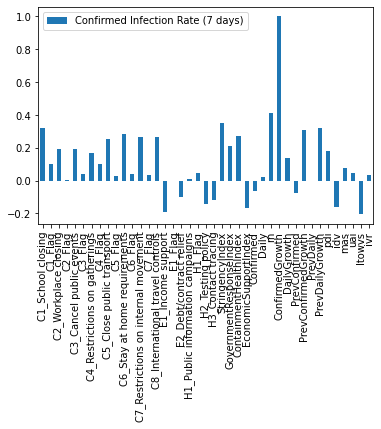

In [ ]:
remove_cols = ['rn','Deaths', ]

govt_response_df = cult_dim_df.copy()
corr_govt_response_df = govt_response_df.copy()

corr_govt_response_df["ConfirmedGrowth"] = govt_response_df["ConfirmedGrowth"].replace(np.inf, np.nan)
corr_govt_reponse_df = corr_govt_response_df.dropna(subset=["ConfirmedGrowth"])

correlation_matrix = corr_govt_response_df.corr()
#correlation = corr_govt_response_df["ConfirmedGrowth"].corr(corr_govt_response_df["StringencyIndex", "S7_Internationaltravel controls"])
correlation_matrix.sort_values(by=["ConfirmedGrowth"])

correlation_matrix.to_csv("feature_corr.csv")

correlation_matrix.plot.bar(y="ConfirmedGrowth", label="Confirmed Infection Rate (7 days)",)

We observe the distribution of the following labels:
- `ConfirmedGrowth`
- `ConfirmedGrowthDiff`

In [ ]:
"""
binwidth = 0.01

column = corr_govt_response_df['ConfirmedGrowth']

bins = np.arange((int(np.nanmin(column)/binwidth)-1) * binwidth, np.nanmax(column) + binwidth, binwidth)
xticks = np.arange((int(np.nanmin(column) / 0.2)-1) * 0.2, np.nanmax(column) + 0.1, 0.1)
plt.hist(column, bins=bins)
plt.xticks(xticks)
plt.xlabel('ConfirmedGrowth')
plt.ylabel('Frequency')
plt.grid()

display('Mean:' + str(column.mean())+'  Median: '+str(column.median())+'  StD: '+str(column.std()) )
display('Max:' + str(column.max())+'  Min:'+str(column.min()))
"""

"\nbinwidth = 0.01\n\ncolumn = corr_govt_response_df['ConfirmedGrowth']\n\nbins = np.arange((int(np.nanmin(column)/binwidth)-1) * binwidth, np.nanmax(column) + binwidth, binwidth)\nxticks = np.arange((int(np.nanmin(column) / 0.2)-1) * 0.2, np.nanmax(column) + 0.1, 0.1)\nplt.hist(column, bins=bins)\nplt.xticks(xticks)\nplt.xlabel('ConfirmedGrowth')\nplt.ylabel('Frequency')\nplt.grid()\n\ndisplay('Mean:' + str(column.mean())+'  Median: '+str(column.median())+'  StD: '+str(column.std()) )\ndisplay('Max:' + str(column.max())+'  Min:'+str(column.min()))\n"

##  Create Training, Validation, and Testing Datasets


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
csv_file = "./data/input_df.csv"
df = pd.read_csv(csv_file)
df

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Confirmed,Daily,rn,ConfirmedGrowth,DailyGrowth,PrevConfirmed,PrevConfirmedGrowth,PrevDaily,PrevDailyGrowth,pdi,idv,mas,uai,ltowvs,ivr
0,Seychelles,SYC,2020-06-12,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0,2.0,0.0,1.0,2.0,1.0,2.0,2.0,23.15,35.71,31.25,62.5,11.0,0.0,142,0.000000,0.000000,11.0,0.000000,0.0,0.000000,64.0,27.0,41.0,52.0,32.000000,40.000000
1,Tanzania,TZA,2020-06-12,2.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,32.41,27.08,31.60,0.0,509.0,0.0,142,0.000000,0.000000,509.0,0.000000,0.0,0.000000,80.0,38.0,53.0,68.0,34.005038,38.392857
2,Tanzania,TZA,2020-06-13,2.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,32.41,27.08,31.60,0.0,509.0,0.0,141,0.000000,0.000000,509.0,0.000000,0.0,0.000000,80.0,38.0,53.0,68.0,34.005038,38.392857
3,Tanzania,TZA,2020-06-14,2.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,32.41,27.08,31.60,0.0,509.0,0.0,140,0.000000,0.000000,509.0,0.000000,0.0,0.000000,80.0,38.0,53.0,68.0,34.005038,38.392857
4,Tanzania,TZA,2020-06-15,2.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,32.41,27.08,31.60,0.0,509.0,0.0,139,0.000000,0.000000,509.0,0.000000,0.0,0.000000,80.0,38.0,53.0,68.0,34.005038,38.392857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18978,Brazil,BRA,2020-04-06,3.0,0.0,3.0,0.0,2.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,74.54,67.26,70.14,50.0,36032.4,2484.6,209,2.549920,1.332958,10150.2,7.594581,1065.0,2.431057,69.0,38.0,49.0,76.0,43.828715,59.151786
18979,Chad,TCD,2020-04-06,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,33.33,34.52,31.94,50.0,30.6,2.0,209,2.558140,4.000000,8.6,7.600000,0.4,1.000000,70.5,23.5,43.5,53.0,20.500000,59.000000
18980,South Sudan,SSD,2020-05-20,3.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0,73.15,67.86,75.00,25.0,994.0,0.0,165,2.560172,-1.000000,279.2,4.651822,10.8,3.153846,64.0,27.0,41.0,52.0,32.000000,40.000000
18981,Ethiopia,ETH,2020-05-19,3.0,1.0,2.0,1.0,2.0,1.0,4.0,1.0,2.0,0.0,1.0,1.0,2.0,0.0,3.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,80.56,66.67,73.61,25.0,1160.8,102.6,166,2.567302,4.516129,325.4,1.371720,18.6,5.642857,80.0,38.0,53.0,68.0,23.000000,46.000000


### Data Processing
We process our data into a format that is compatible with our model.

We create three DataFrames.  The first DataFrame retains the same format as the one loaded from the .csv file.  The second and third DataFrames modify the format as such:
- For policies S1 to S7, only countrywide measures would be counted.  That is, if its corresponding `IsGeneral` column is 0, regardless of the value, the value will be set to 0.  This is a <strong>weighted</strong> method.
- For policies S1 to S6, the sum of each measure's value and `IsGeneral` column is taken, creating a score ranging from 0 to 3 (except for S5, which is 0 to 2).  This method is based on the <strong>Stringency Index</strong> described in https://www.bsg.ox.ac.uk/sites/default/files/2020-04/BSG-WP-2020-031-v4.0_0.pdf
- We also include the changes in policy from each date range. 

From a feature processing perspective, these different formats may be considered to be different kernels.

NOTE: The below code assumes that all measures with an `IsGeneral` column has a lower `S` value than all measures which do not. (E.g., S1 to S6 have `IsGeneral` column and S7+ do not have `IsGeneral` column.)

In [ ]:
# create DataFrame with StringencyIndex method
stringencyidx_df = df.copy()

"""
for i in range(0, num_policies):
    if len(isgeneral_cols) > i:
        stringencyidx_df[policy_cols[i]] = stringencyidx_df[policy_cols[i]] + stringencyidx_df[isgeneral_cols[i]]

stringencyidx_df = stringencyidx_df.drop(columns=isgeneral_cols)
stringencyidx_df.plot.scatter(x="StringencyIndex", y="ConfirmedGrowth")
stringencyidx_df.to_csv("stringencyidx_df.csv")
"""
feat_max = {
    'C1_School closing': 3,
    'C2_Workplace closing': 3,
    'C3_Cancel public events': 2,
    'C4_Restrictions on gatherings': 4,
    'C5_Close public transport': 2, 
    'C6_Stay at home requirements': 3, 
    'C7_Restrictions on internal movement': 2,
    'C8_International travel controls': 4, 
    'E1_Income support': 2,
    'E2_Debt/contract relief': 2,
    'H1_Public information campaigns': 2,
    'H2_Testing policy': 3,
    'H3_Contact tracing': 2
}

flag_max = {
    'C1_Flag': 1, 
    'C2_Flag': 1, 
    'C3_Flag': 1, 
    'C4_Flag': 1, 
    'C5_Flag': 1, 
    'C6_Flag': 1, 
    'C7_Flag': 1, 
    'E1_Flag': 1,
    'H1_Flag': 1,
}

for feature in feat_max:
  code = feature[:3]
  if code+"Flag" in flag_max:
    flag = code+"Flag"
    stringencyidx_df[feature] = (stringencyidx_df[feature] 
                                 - 0.5*(float(flag_max[flag]) - stringencyidx_df[flag])) \
                                 / float(feat_max[feature])
  else:
    stringencyidx_df[feature] = stringencyidx_df[feature] / float(feat_max[feature])

stringencyidx_df = stringencyidx_df.drop(columns=list(flag_max.keys()))
stringencyidx_df.sort_values(by="Date")

,CountryName,CountryCode,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Confirmed,Daily,rn,ConfirmedGrowth,DailyGrowth,PrevConfirmed,PrevConfirmedGrowth,PrevDaily,PrevDailyGrowth,pdi,idv,mas,uai,ltowvs,ivr
18916,Saudi Arabia,SAU,2020-04-01,1.000000,0.666667,1.0,0.75,1.00,0.666667,1.00,1.0,-0.25,0.0,1.0,0.666667,1.0,89.81,69.64,81.25,0.0,4932.0,442.2,214,2.407019,2.589286,1447.6,9.867868,123.2,6.247059,80.0,38.0,53.0,68.0,35.516373,52.232143
18294,Mauritius,MUS,2020-04-01,1.000000,1.000000,1.0,0.75,0.50,0.666667,0.50,1.0,0.50,0.5,1.0,0.333333,0.5,82.41,66.07,68.75,50.0,323.0,1.2,214,1.519501,-0.910448,128.2,212.666667,13.4,21.333333,64.0,27.0,41.0,52.0,32.000000,40.000000
12510,Vietnam,VNM,2020-04-01,1.000000,1.000000,1.0,1.00,1.00,0.666667,1.00,1.0,-0.25,0.0,1.0,0.666667,1.0,96.30,77.38,90.28,0.0,263.6,2.0,214,0.324623,-0.818182,199.0,2.199357,11.0,0.964286,70.0,20.0,40.0,30.0,57.178841,35.491071
18019,Finland,FIN,2020-04-01,0.666667,0.333333,1.0,1.00,-0.25,0.333333,0.75,1.0,1.00,0.0,1.0,0.333333,0.5,67.59,56.55,57.64,50.0,3068.2,93.6,214,1.316322,0.155556,1324.6,3.720599,81.0,1.237569,33.0,63.0,26.0,59.0,38.287154,57.366071
18022,New Zealand,NZL,2020-04-01,1.000000,1.000000,1.0,1.00,1.00,0.666667,1.00,1.0,0.75,0.5,1.0,0.666667,1.0,96.30,82.74,86.11,62.5,1348.6,20.6,214,1.317979,-0.697059,581.8,52.870370,68.0,21.666667,22.0,79.0,58.0,49.0,32.745592,74.553571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18555,Jordan,JOR,2020-09-30,1.000000,0.666667,1.0,0.75,0.50,0.333333,0.00,0.5,0.25,0.5,1.0,0.666667,1.0,63.89,61.90,65.97,37.5,26734.8,1557.4,32,1.805154,0.687690,9530.6,1.733494,922.8,4.087100,80.0,38.0,53.0,68.0,16.120907,43.080357
8483,Norway,NOR,2020-09-30,0.000000,0.333333,0.0,0.75,0.00,-0.166667,0.00,0.5,0.75,1.0,1.0,0.666667,1.0,28.70,44.64,37.50,87.5,15675.0,113.0,32,0.134965,0.172199,13811.0,0.124674,96.4,-0.026263,31.0,69.0,8.0,50.0,34.508816,55.133929
669,Malawi,MWI,2020-09-30,0.666667,0.666667,1.0,0.75,-0.25,0.333333,-0.25,0.5,0.00,1.0,1.0,0.333333,1.0,54.63,53.57,54.17,50.0,5824.4,3.2,32,0.009463,0.777778,5769.8,0.013312,1.8,-0.742857,64.0,27.0,41.0,52.0,32.000000,40.000000
3134,Benin,BEN,2020-09-30,0.666667,0.333333,0.5,0.75,-0.25,-0.166667,0.50,0.5,0.75,0.5,1.0,0.666667,1.0,47.22,56.55,55.56,62.5,2424.4,13.4,32,0.035891,1.093750,2340.4,0.033472,6.4,-0.157895,77.0,20.0,46.0,54.0,9.000000,78.000000


### Training, Validation, and Test Sets
We split our dataset into the following ratios:
- 70% for training
- 15% for validation
- 15% for test

Because the features and labels contain no sequential markers (e.g., country or date) between them, the data may be shuffled without considering time series information leaking into the training data.  On the contrary, if we do not shuffle the data when separating into datasets, our results will not be generalizable for past data.

In [ ]:
features_df = stringencyidx_df.copy()

ratio = {'train': 0.7, 'valid': 0.15, 'test': 0.15}

ordered_df = features_df.sort_values(by=['CountryName', 'Date'])
ordered_df['rn'] = ordered_df.groupby(['CountryName']).cumcount()

if time_series_split_method:
    train_df = ordered_df.groupby("CountryName", group_keys=False).apply(lambda x: x.nsmallest(math.ceil(len(x) * ratio['train']), 'rn'))
    valid_test_df = ordered_df.groupby("CountryName", group_keys=False).apply(lambda x: x.nlargest(math.floor(len(x) * (ratio['valid']+ratio['test'])), 'rn'))
else:
    valid_test_df, train_df = train_test_split(ordered_df, test_size=0.7, random_state=seed)

display("Train Mean: "+str(train_df[label_name].mean())+"   StD: "+str(train_df[label_name].std())+ "   Count: "+str(train_df[label_name].count()))

'Train Mean: 0.4269373867444416   StD: 0.49643112324373834   Count: 13362'

In [ ]:
split_ratio = float(ratio['valid']/(ratio['valid']+ratio['test']))

valid_df, test_df = train_test_split(valid_test_df, test_size=split_ratio, random_state=seed)

display("Valid Mean: "+str(valid_df[label_name].mean())+"   StD: "+str(valid_df[label_name].std())+ "   Count: "+str(valid_df[label_name].count()))
display("Test Mean: "+str(test_df[label_name].mean())+"   StD: "+str(test_df[label_name].std())+ "   Count: "+str(test_df[label_name].count()))

'Valid Mean: 0.16970859499996319   StD: 0.2101245211663372   Count: 2810'

'Test Mean: 0.17289574713111358   StD: 0.22519524147765269   Count: 2811'

#### Separating Features from Labels

In [ ]:
# remove from DataFrame
markers = ['CountryName', 'CountryCode', 'Date', 'rn', 'Confirmed', 'Daily']
label_names = [label_name]

train_feats = train_df.drop(columns=label_names+markers+features_to_exclude)
train_labels = train_df[label_names]

valid_feats = valid_df.drop(columns=label_names+markers+features_to_exclude)
valid_labels = valid_df[label_names]

test_feats = test_df.drop(columns=label_names+markers+features_to_exclude)
test_labels = test_df[label_names]
train_feats

train_feats.to_csv("train.csv")
train_labels[label_name].to_csv("label.csv")

#### Normalizing the Data
Because our features are ordinal, we use SKLearn's `MinMaxScaler` to scale our data in the range [0, 1].  Note that `StandardScaler` which scales with variance is unsuitable, because it assumes a Gaussian distribution. 

In [ ]:
scaler = MinMaxScaler()

norm_feats = {'train': None, 'test': None}

scaler.fit(train_feats)
norm_feats['train'] = scaler.transform(train_feats)
norm_feats['valid'] = scaler.transform(valid_feats)
norm_feats['test'] = scaler.transform(test_feats)

## Feature Selection
In order to reduce over-fitting, we reduce the number of features by ranking features based on the following metrics:

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression

We first get the names of each of the features in the training dataset.

In [ ]:
# create dictionary to store selection metrics
feat_select_df = {}

# get column names of features
feat_names = train_feats.columns.to_list()
feat_names

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'E1_Income support',
 'E2_Debt/contract relief',
 'H1_Public information campaigns',
 'H2_Testing policy',
 'H3_Contact tracing',
 'StringencyIndex',
 'GovernmentResponseIndex',
 'ContainmentHealthIndex',
 'EconomicSupportIndex',
 'PrevConfirmed',
 'PrevConfirmedGrowth',
 'pdi',
 'idv',
 'mas',
 'uai',
 'ltowvs',
 'ivr']

### Compute Feature Selection Metrics

#### F-Regression
https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2

,feat_name,f_score,p_value
0,C1_School closing,1622.134358,0.000000e+00
1,C2_Workplace closing,528.695430,9.048264e-115
2,C3_Cancel public events,540.275679,3.421137e-117
3,C4_Restrictions on gatherings,538.320564,8.769999e-117
4,C5_Close public transport,806.722607,2.335491e-172
5,C6_Stay at home requirements,1260.878860,5.434217e-264
6,C7_Restrictions on internal movement,1167.682370,2.003132e-245
7,C8_International travel controls,727.081334,5.556041e-156
8,E1_Income support,548.521844,6.463960e-119
9,E2_Debt/contract relief,207.446863,1.107623e-46


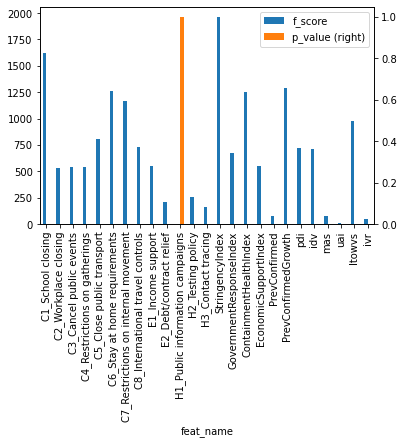

In [ ]:
# compute f-score of each feature
f_scores, p_values = f_regression(norm_feats['train'], train_labels[label_name])

feat_select_df['f_score'] = pd.DataFrame.from_dict({'feat_name': feat_names, 'f_score': f_scores, 'p_value': p_values})
feat_select_df['f_score'].plot.bar(x="feat_name", y=["f_score", "p_value"], secondary_y="p_value")

display(feat_select_df['f_score'])


#### Mutual Information

,feat_name,mutual_info
0,C1_School closing,0.205475
1,C2_Workplace closing,0.127213
2,C3_Cancel public events,0.102139
3,C4_Restrictions on gatherings,0.111973
4,C5_Close public transport,0.124086
5,C6_Stay at home requirements,0.162501
6,C7_Restrictions on internal movement,0.146160
7,C8_International travel controls,0.098504
8,E1_Income support,0.109624
9,E2_Debt/contract relief,0.052666


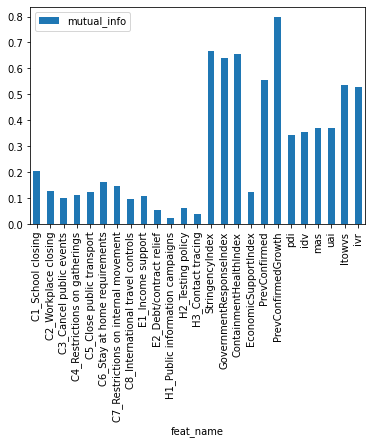

In [ ]:
# compute mutual information of each feature
mutual_info = mutual_info_regression(norm_feats['train'], train_labels[label_name], random_state=seed)

feat_select_df['mutual_info'] = pd.DataFrame.from_dict({'feat_name': feat_names, 'mutual_info': mutual_info})

feat_select_df['mutual_info'].plot.bar(x="feat_name", y="mutual_info")

feat_select_df['mutual_info']

### Selecting Features
In this section, we select the features which meets all of our criteria:
- `p_value <= 0.05`
- `mutual_info > 0.10`

The parameter `both_thresholds` indicates whether an AND operation is used for both threshold.  When `both_thresholds` is False, either an OR operation is used or only 1 of the thresholds are used.  The thresholds to use are indicated in `threshold_to_use` with options: `f_score` and `mutual_info`.

In [ ]:
feats_idx_to_keep_fscore = feat_select_df['f_score'].loc[feat_select_df['f_score']['p_value'] <= p_threshold].index.astype(int).to_list()
feats_idx_to_keep_mi = feat_select_df['mutual_info'].loc[feat_select_df['mutual_info']['mutual_info'] >= mi_threshold].index.astype(int).to_list()

feats_idx_to_keep = []

# combine thresholds
if both_thresholds:
  feats_idx_to_keep = list(set(feats_idx_to_keep_fscore) & set(feats_idx_to_keep_mi))
else:
  if 'f_score' in threshold_to_use:
    feats_idx_to_keep += feats_idx_to_keep_fscore
  if 'mutual_info' in threshold_to_use:
    feats_idx_to_keep += feats_idx_to_keep_mi 
  feats_idx_to_keep = list(set(feats_idx_to_keep))

display(feats_idx_to_keep)

# remove features from training, validation, and test data
sel_norm_feats = {}

for key in norm_feats:
    sel_norm_feats[key] = norm_feats[key][:, feats_idx_to_keep]

display(sel_norm_feats)

[0, 1, 2, 3, 4, 5, 6, 8, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

{'test': array([[0.71428571, 0.71428571, 0.2       , ..., 0.81730769, 0.38309859,
         0.29241071],
        [1.        , 0.85714286, 0.8       , ..., 0.75      , 0.30704225,
         0.68      ],
        [0.14285714, 0.        , 0.2       , ..., 0.58653846, 1.        ,
         0.49107143],
        ...,
        [1.        , 0.71428571, 1.        , ..., 0.20192308, 0.64225352,
         0.16964286],
        [0.71428571, 0.71428571, 1.        , ..., 0.57692308, 0.21777465,
         0.34      ],
        [0.14285714, 0.14285714, 0.2       , ..., 0.59615385, 0.67605634,
         0.56026786]]),
 'train': array([[1.        , 0.85714286, 1.        , ..., 0.57692308, 0.25070423,
         0.32366071],
        [1.        , 0.85714286, 1.        , ..., 0.57692308, 0.25070423,
         0.32366071],
        [1.        , 0.85714286, 1.        , ..., 0.57692308, 0.25070423,
         0.32366071],
        ...,
        [1.        , 0.42857143, 1.        , ..., 0.57692308, 0.13239437,
         0.276785

We plot the p-value and mutual information together in the same bar graph.

<Figure size 432x288 with 0 Axes>

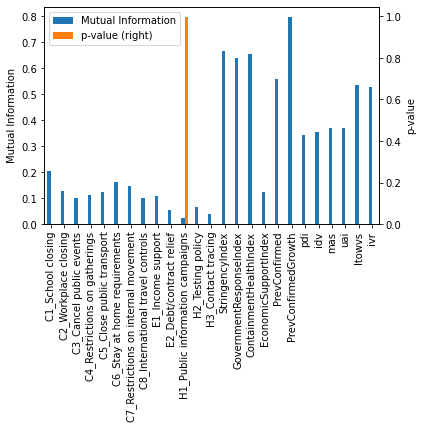

In [ ]:
feat_select_df['plot'] = pd.merge(feat_select_df['f_score'], feat_select_df['mutual_info'],
                                  how='left', left_on=['feat_name'], right_on=['feat_name'])

# rename columns
feat_select_df['plot'] = feat_select_df['plot'].rename(columns={"feat_name": "Feature", 
                                                                "mutual_info": "Mutual Information",
                                                                "p_value": "p-value",
                                                                "f_score": "F-Score"})

# plot as bar graph
plt.figure()
feat_select_df['plot'][['Feature', 'Mutual Information', 'p-value']].plot(kind='bar',
                                                                          x='Feature',
                                                                          secondary_y='p-value')

ax1, ax2 = plt.gcf().get_axes() 

ax1.set_ylabel('Mutual Information')
ax2.set_ylabel('p-value')

ax1.set_xlabel("")
ax2.set_xlabel("")

plt.savefig("./figures/feat_selection.png", bbox_inches = "tight", dpi=1000)

## Balancing Training Data
Data for dates where there are higher ConfirmedGrowth are less frequent.  As a consequence, the model may be biased towards and perform well on dates with low ConfirmedGrowth, but fail on dates with high ConfirmedGrowth.  To mitigate this, we use a balancing strategy to compensate for dates with higher ConfirmedGrowth.

In [ ]:
if use_smogn:
    !pip install smogn

    import smogn
    import seaborn

    smogn.smoter.__code__.co_varnames

When joining the features and labels, we only include the label which we want to predict.  This prevents information from other labels leaking into the sampling method.

In [ ]:
if use_smogn:
    imbalanced_train_feats = sel_norm_feats['train'].copy()
    num_feats = imbalanced_train_feats.shape[1]
    imbalanced_train_labels = np.reshape(train_labels[label_name].to_numpy(), (-1, 1))
    label_cols = [label_name]

    columns = ["F"+str(i) for i in range(num_feats)]+label_cols
    display(columns)

    imbalanced_train_data = np.concatenate((imbalanced_train_feats, imbalanced_train_labels), axis=1) 
    imbalanced_train_data = pd.DataFrame(data=imbalanced_train_data, columns=columns)
    imbalanced_train_data

### SMOGN
We use the SMOGN balancing technique for generating minority imbalance regression data.

https://www.kaggle.com/aleksandradeis/regression-addressing-extreme-rare-cases

https://github.com/nickkunz/smogn

http://proceedings.mlr.press/v74/branco17a/branco17a.pdf

NOTE: The SMOGN function currently has no random seed.  Therefore, every run will lead to different samples in the balanced training data.

In [ ]:
if use_smogn:
    display(imbalanced_train_data)
    balanced_train_data = smogn.smoter(data=imbalanced_train_data, y=label_name, samp_method="balance", rel_thres=0.1)
    

In [ ]:
if use_smogn:
    h = seaborn.kdeplot(imbalanced_train_data['ConfirmedGrowth'], label = "Original")
    h = seaborn.kdeplot(balanced_train_data['ConfirmedGrowth'], label = "Modified")

    h.set(xlim=(-0.25, 3))

    smogn.box_plot_stats

In [ ]:
if use_smogn:
    train_labels = pd.DataFrame(balanced_train_data[label_name])
    sel_norm_feats['train'] = balanced_train_data.drop(columns=[label_name]).to_numpy()

    train_labels

## Model Fitting

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, recall_score, precision_score, roc_auc_score, confusion_matrix, f1_score, average_precision_score

from sklearn.externals import joblib

In [ ]:
def calculate_prediction_factor(predict_labels, true_labels, remove_threshold=0.005):
    """
    Calculate the prediction factor f = prediction/label. Note that label is the numerator to prevent dividing by 0.
    Prediction is rarely 0.
    Arguments:
        - predict_labels (np.array) :      1D numpy array of predicted labels
        - true_labels (np.array) :         1D numpy array of true labels
        - remove_threshold (float) :       remove labels lower than this (None includes all)
    """
    median_prediction_factor = None
    """
    if remove_threshold is not None:
        zero_indices = np.where(true_labels <= remove_threshold)
        true_labels = np.delete(true_labels, zero_indices)
        predict_labels = np.delete(predict_labels, zero_indices)
    """
    prediction_factors = predict_labels / true_labels 

    # if prediction factor contains 0/0 = Nan
    where_are_NaNs = np.isnan(prediction_factors)
    prediction_factors[where_are_NaNs] = 1

    #prediction_factors[prediction_factors == np.nan] = 1
    
    if np.count_nonzero(np.isnan(prediction_factors)) > 0:
      df = {'predict': predict_labels.tolist(), 'true': true_labels.tolist(), 'pf': prediction_factors.tolist()}
      df = pd.DataFrame.from_dict(df)
      df.to_csv('./results/df'+'.csv')
      
    median_prediction_factor = np.median(prediction_factors)
    
    # convert np.inf to np.nan
    prediction_factors[prediction_factors == np.inf] = np.nan 
    
    return median_prediction_factor, prediction_factors

In [ ]:
model_filenames = {'LinearRegression': "./models/lr.pkl",
             'LinearRegressionReg': "./models/lr_reg.pkl",
             'DecisionTree': "./models/tree.pkl",
             'BagLinearRegression': "./models/lr_bag.pkl",
             'RandomForest': "./models/rf.pkl",
             'SVR': "./models/svr.pkl",
             'NeuralNetwork': "./models/nn.pkl",
             'AdaBoost': "./models/adaboost.pkl"
}

if not os.path.exists('models'):
    os.makedirs('models')

In [ ]:
feats = sel_norm_feats
train_features = feats['train']
valid_features = feats['valid']
test_features = feats['test']

#### Identifying Best Performing Hyperparameters
For each model, we try out different hyperparameter configurations.  The configuration resulting in the lowest error in the validation set is considered the best performing.

In [ ]:
top_model_configs = {}

### Linear Regression with Regularization

https://stats.stackexchange.com/questions/195246/how-to-handle-ordinal-categorical-variable-as-independent-variable

### Linear Regression

In [ ]:
if run_models['LinearRegression']:
  lr_regressor = LinearRegression().fit(train_features, train_labels[label_name])

  train_predict = lr_regressor.predict(train_features)
  valid_predict = lr_regressor.predict(valid_features)

  train_error = mean_absolute_error(train_labels[label_name], train_predict)
  valid_error = mean_absolute_error(valid_labels[label_name], valid_predict)

  mean_predict_factor, prediction_factors = calculate_prediction_factor(valid_predict, valid_labels[label_name].to_numpy(), p_factor_threshold)

  _ = joblib.dump(lr_regressor, model_filenames['LinearRegression'])

  top_model_configs['LinearRegression'] = {"train_error": train_error, "valid_error": valid_error, "predict_factor": mean_predict_factor}
  top_model_configs

### Linear Regression with L2 Regularization (Ridge Regression)

In [ ]:
if run_models['LinearRegressionReg']:
  alphas = list(np.arange(0, 1.25, 0.25))

  results = {'alpha': [], 'valid_error': [], 'train_error': [], 'predict_factor': []}

  min_error = None

  for alpha in alphas:
      ridge_regressor = Ridge(alpha=alpha, random_state=seed).fit(train_features, train_labels[label_name])

      train_predict = ridge_regressor.predict(train_features)
      valid_predict = ridge_regressor.predict(valid_features)
      valid_error = mean_absolute_error(valid_labels[label_name], valid_predict)
      train_error = mean_absolute_error(train_labels[label_name], train_predict)
      
      mean_predict_factor, prediction_factors = calculate_prediction_factor(valid_predict, 
                                                                            valid_labels[label_name].to_numpy(),
                                                                            p_factor_threshold)

      # update best performing hyperparamters
      if min_error is None:
          min_error = valid_error
          top_model_configs['LinearRegressionReg'] = {'alpha': alpha, 'valid_error': valid_error, 
                                                      'train_error': train_error, "predict_factor": mean_predict_factor}
          _ = joblib.dump(ridge_regressor, model_filenames['LinearRegressionReg'])
      else:
          if valid_error < min_error:
              min_error = valid_error
              top_model_configs['LinearRegressionReg'] = {'alpha': alpha, 'valid_error': valid_error, 
                                                          'train_error': train_error, "predict_factor": mean_predict_factor}
              _ = joblib.dump(ridge_regressor, model_filenames['LinearRegressionReg'])
      
      results['alpha'].append(alpha)
      results['valid_error'].append(valid_error)
      results['train_error'].append(train_error)
      results['predict_factor'].append(mean_predict_factor)
      
      display("Alpha: "+str(alpha)+"   Abs Error: "+str(train_error))

  results_df = pd.DataFrame.from_dict(results)
  results_df


### Decision Tree Regression

In [ ]:
if run_models['DecisionTree']:
  criterion='mse'
  splitter='best'
  depths= [5, 10, 15, 20, 25, 30]
  min_samples_splits = [2, 5, 10]
  min_samples_leaves = [1, 2, 4, 8, 10]
  num_features = ['log2']

  results = {'criterion': [], 'depth': [], 'split': [], 'leaf': [], 'features': [], 
            'valid_error': [], 'train_error': [], 'predict_factor': []}

  min_error = None

  for depth in depths:
      for split in min_samples_splits:
          for leaf in min_samples_leaves:
              for n_features in num_features:
              
                  tree_regressor = DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_depth=depth, \
                                                        min_samples_split=split, min_samples_leaf=leaf, \
                                                        max_features=n_features, random_state=seed)
                  tree_regressor = tree_regressor.fit(train_features, train_labels[label_name])

                  train_predict = tree_regressor.predict(train_features)
                  valid_predict = tree_regressor.predict(valid_features)
                  valid_error = mean_absolute_error(valid_labels[label_name], valid_predict)
                  train_error = mean_absolute_error(train_labels[label_name], train_predict)
                  mean_predict_factor, prediction_factors = calculate_prediction_factor(valid_predict, 
                                                                                        valid_labels[label_name].to_numpy(), 
                                                                                        p_factor_threshold)

                  # update best performing hyperparamters
                  if min_error is None:
                      min_error = valid_error
                      top_model_configs['DecisionTree'] = {'depth': depth, 'split': split, 'leaf': leaf, 
                                                          'n_features': n_features, 'valid_error': valid_error, 
                                                          'train_error': train_error, 'predict_factor': mean_predict_factor}
                      _ = joblib.dump(tree_regressor, model_filenames['DecisionTree'])
                  else:
                      if valid_error < min_error:
                          min_error = valid_error
                          top_model_configs['DecisionTree'] = {'depth': depth, 'split': split, 'leaf': leaf, 
                                                              'n_features': n_features, 'valid_error': valid_error, 
                                                              'train_error': train_error, 'predict_factor': mean_predict_factor}
                          _ = joblib.dump(tree_regressor, model_filenames['DecisionTree'])

                  results['criterion'].append(criterion)
                  results['depth'].append(depth)
                  results['split'].append(split)
                  results['leaf'].append(leaf)
                  results['features'].append(n_features)
                  results['valid_error'].append(valid_error)
                  results['train_error'].append(train_error)
                  results['predict_factor'].append(mean_predict_factor)

  results_df = pd.DataFrame.from_dict(results)
  display(top_model_configs)

### Bagging Linear Regression

In [ ]:
if run_models['BagLinearRegression']:
  num_estimators = list(range(5, 21, 5))
  num_samples = [0.5, 0.75, 1.0]
  num_features = [0.5, 0.75, 1.0]

  results = {'estimators': [], 'samples': [], 'features': [], 
            'valid_error': [], 'train_error': [], 'predict_factor': []}

  min_error = None

  for num_estimator in num_estimators:
      for samples in num_samples:
          for features in num_features:
              
              bag_regressor = BaggingRegressor(LinearRegression(), n_estimators=num_estimator, max_samples=samples, \
                                              max_features=features, random_state=seed)
              
              bag_regressor = bag_regressor.fit(train_features, train_labels[label_name])
              train_predict = bag_regressor.predict(train_features)
              valid_predict = bag_regressor.predict(valid_features)
              train_error = mean_absolute_error(train_labels[label_name], train_predict)
              valid_error = mean_absolute_error(valid_labels[label_name], valid_predict)
              mean_predict_factor, prediction_factors = calculate_prediction_factor(valid_predict, 
                                                                                    valid_labels[label_name].to_numpy(),
                                                                                    p_factor_threshold)
              
              # update best performing hyperparamters
              if min_error is None:
                  min_error = valid_error
                  top_model_configs['BagLinearRegression'] = {'estimators': num_estimator, 'samples': samples, 
                                                              'features': features, 'valid_error': valid_error, 
                                                              'train_error': train_error, 'predict_factor': mean_predict_factor}
                  _ = joblib.dump(bag_regressor, model_filenames['BagLinearRegression'])
              else:
                  if valid_error < min_error:
                      min_error = valid_error
                      top_model_configs['BagLinearRegression'] = {'estimators': num_estimator, 'samples': samples, 
                                                                  'features': features, 'valid_error': valid_error, 
                                                                  'train_error': train_error, 'predict_factor': mean_predict_factor}
                      _ = joblib.dump(bag_regressor, model_filenames['BagLinearRegression'])
              
              #display("Estimators: "+str(num_estimator)+"   Samples: "+str(samples)+"   Features: "+str(features)+"   Valid Error: "+str(valid_error))
              
              results['estimators'].append(num_estimator)
              results['samples'].append(samples)
              results['features'].append(features)
              results['valid_error'].append(valid_error)
              results['train_error'].append(train_error)
              results['predict_factor'].append(mean_predict_factor)

  results_df = pd.DataFrame.from_dict(results)
  results_df


### AdaBoost Regression

In [ ]:
if run_models['AdaBoost']:

  weak_learner = DecisionTreeRegressor(max_depth=3)

  n_estimators = [3, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150]
  learning_rates = [0.1, 0.5, 1]
  loss = 'linear'
  min_error = None

  results = {'loss': [], 'estimators': [], 'learning_rate': [],
            'valid_error': [], 'train_error': [], 'predict_factor': []}

  for num_estimator in n_estimators:
      for learning_rate in learning_rates:
          
        adaboost_regressor = AdaBoostRegressor(base_estimator=weak_learner, 
                                              n_estimators=num_estimator, 
                                              loss=loss, 
                                              learning_rate=learning_rate,
                                              random_state=seed)

        adaboost_regressor = adaboost_regressor.fit(train_features, train_labels[label_name])
        train_predict = adaboost_regressor.predict(train_features)
        valid_predict = adaboost_regressor.predict(valid_features)
        train_error = mean_absolute_error(train_labels[label_name], train_predict)
        valid_error = mean_absolute_error(valid_labels[label_name], valid_predict)
        mean_predict_factor, prediction_factors = calculate_prediction_factor(valid_predict, 
                                                                              valid_labels[label_name].to_numpy(),
                                                                              p_factor_threshold)
        # update best performing hyperparamters
        if min_error is None:
            min_error = valid_error
            top_model_configs['AdaBoost'] = {'estimators': num_estimator, 
                                            'loss': loss, 
                                            'learning_rate': learning_rate, 
                                            'valid_error': valid_error, 'train_error': train_error,
                                            'predict_factor': mean_predict_factor}
            _ = joblib.dump(adaboost_regressor, model_filenames['AdaBoost'])

        else:
            if valid_error < min_error:
                min_error = valid_error
                top_model_configs['AdaBoost'] = {'estimators': num_estimator, 
                                            'loss': loss, 
                                            'learning_rate': learning_rate, 
                                            'valid_error': valid_error, 'train_error': train_error,
                                            'predict_factor': mean_predict_factor}
                _ = joblib.dump(adaboost_regressor, model_filenames['AdaBoost'])

        results['loss'].append(loss)
        results['estimators'].append(num_estimator)
        results['learning_rate'].append(learning_rate)
        results['valid_error'].append(valid_error)
        results['train_error'].append(train_error)
        results['predict_factor'].append(mean_predict_factor)
      
  results_df = pd.DataFrame.from_dict(results)
  display(results_df)

  display(top_model_configs)

,loss,estimators,learning_rate,valid_error,train_error,predict_factor
0,linear,3,0.1,0.082734,0.198853,1.240288
1,linear,3,0.5,0.082097,0.196933,1.311111
2,linear,3,1.0,0.092296,0.206888,1.541393
3,linear,5,0.1,0.083371,0.197701,1.238924
4,linear,5,0.5,0.083413,0.199252,1.284117
5,linear,5,1.0,0.081460,0.207433,1.403826
6,linear,10,0.1,0.085320,0.200306,1.307323
7,linear,10,0.5,0.084336,0.204841,1.288905
8,linear,10,1.0,0.087927,0.212895,1.494142
9,linear,15,0.1,0.086879,0.202466,1.347007


{'AdaBoost': {'estimators': 5,
  'learning_rate': 1,
  'loss': 'linear',
  'predict_factor': 1.4038257844850461,
  'train_error': 0.2074328337795169,
  'valid_error': 0.08146036389967758}}

### Random Forest Regression

In [ ]:
if run_models['RandomForest']:
  n_estimators = [3, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150]
  criterion = 'mse' 
  depths= [5, 10, 15, 20, 25, 30]
  min_samples_splits = [2, 5, 10]
  min_samples_leaves = [1, 2, 4, 8, 10]
  num_features = ['log2']
              
  num_features = ['log2']

  min_error = None

  results = {'criterion': [], 'estimators': [], 'depth': [], 'split': [], 'leaf': [], 'features': [], 
            'valid_error': [], 'train_error': [], 'predict_factor': []}

  for num_estimator in n_estimators:
      for depth in depths:
          for split in min_samples_splits:
              for leaf in min_samples_leaves:
                  for n_features in num_features:
                      rf_regressor = RandomForestRegressor(n_estimators=num_estimator, criterion=criterion, max_depth=depth, \
                                                          min_samples_split=split, min_samples_leaf=leaf, \
                                                          max_features=n_features, random_state=seed)

                      rf_regressor = rf_regressor.fit(train_features, train_labels[label_name])
                      train_predict = rf_regressor.predict(train_features)
                      valid_predict = rf_regressor.predict(valid_features)
                      train_error = mean_absolute_error(train_labels[label_name], train_predict)
                      valid_error = mean_absolute_error(valid_labels[label_name], valid_predict)
                      mean_predict_factor, prediction_factors = calculate_prediction_factor(valid_predict, 
                                                                                            valid_labels[label_name].to_numpy(),
                                                                                            p_factor_threshold)
    
                      # update best performing hyperparamters
                      if min_error is None:
                          min_error = valid_error
                          top_model_configs['RandomForest'] = {'estimators': num_estimator, 'depth': depth, 
                                                              'split': split, 'leaf': leaf, 'n_features': n_features, 
                                                              'valid_error': valid_error, 'train_error': train_error,
                                                              'predict_factor': mean_predict_factor}
                          _ = joblib.dump(rf_regressor, model_filenames['RandomForest'])

                      else:
                          if valid_error < min_error:
                              min_error = valid_error
                              top_model_configs['RandomForest'] = {'estimators': num_estimator, 'depth': depth, 
                                                                  'split': split, 'leaf': leaf, 'n_features': n_features,
                                                                  'valid_error': valid_error, 'train_error': train_error,
                                                                  'predict_factor': mean_predict_factor}
                              _ = joblib.dump(rf_regressor, model_filenames['RandomForest'])

                      results['criterion'].append(criterion)
                      results['estimators'].append(num_estimator)
                      results['depth'].append(depth)
                      results['split'].append(split)
                      results['leaf'].append(leaf)
                      results['features'].append(n_features)
                      results['valid_error'].append(valid_error)
                      results['train_error'].append(train_error)
                      results['predict_factor'].append(mean_predict_factor)
      
  results_df = pd.DataFrame.from_dict(results)
  display(results_df)

  display(top_model_configs)

### Support Vector Regression

In [ ]:
if run_models['SVR']:
  kernels = ['linear', 'rbf', 'sigmoid']
  epsilons = [0, 0.1, 0.2, 0.5]

  results = {'kernel': [], 'epsilon': [], 
            'valid_error': [], 'train_error': [], 'predict_factor': []}

  min_error = None

  for kernel in kernels:
      for epsilon in epsilons:
          sv_regressor = SVR(kernel=kernel, epsilon=epsilon).fit(train_features, train_labels[label_name])
          
          train_predict = sv_regressor.predict(train_features)
          valid_predict = sv_regressor.predict(valid_features)
          train_error = mean_absolute_error(train_labels[label_name], train_predict)
          valid_error = mean_absolute_error(valid_labels[label_name], valid_predict)
          mean_predict_factor, prediction_factors = calculate_prediction_factor(valid_predict, 
                                                                                valid_labels[label_name].to_numpy(),
                                                                                p_factor_threshold)

          # update best performing hyperparamters
          if min_error is None:
              min_error = valid_error
              top_model_configs['SVR'] = {'kernel': kernel, 'epsilon': epsilon, 'valid_error': valid_error, 
                                          'train_error': train_error, 'predict_factor': mean_predict_factor}
              _ = joblib.dump(sv_regressor, model_filenames['SVR'])

          else:
              if valid_error < min_error:
                  min_error = valid_error
                  top_model_configs['SVR'] = {'kernel': kernel, 'epsilon': epsilon, 'valid_error': valid_error, 
                                              'train_error': train_error, 'predict_factor': mean_predict_factor}
                  _ = joblib.dump(sv_regressor, model_filenames['SVR'])
          
          results['kernel'].append(kernel)
          results['epsilon'].append(epsilon)
          results['valid_error'].append(valid_error)
          results['train_error'].append(train_error)
          results['predict_factor'].append(mean_predict_factor)

  results_df = pd.DataFrame.from_dict(results)
  display(results_df)

  display(top_model_configs)

### Multi-Layer Perceptron

In [ ]:
if run_models['NeuralNetwork']:
  layer_sets = [(40, ), (80), (100, ), (100, 100), (300, 300)]
  activations = ['identity', 'relu']
  alphas = [0, 0.0001, 0.0005]
  learning_rates = [0.0001, 0.0005, 0.001, 0.002]
  max_iter = 2000

  results = {'layers': [], 'activation': [], 'alpha': [], 'learning_rate': [], 'max_iter': [], 
            'valid_error': [], 'train_error': [], 'predict_factor': []}

  min_error = None

  for layers in layer_sets:
      for learning_rate in learning_rates:
          for activation in activations:
              for alpha in alphas:

                  mlp_regressor = MLPRegressor(hidden_layer_sizes=layers, activation=activation, alpha=alpha, \
                                              learning_rate_init=learning_rate, max_iter=max_iter, \
                                              random_state=seed).fit(train_features, train_labels[label_name])
                  
                  train_predict = mlp_regressor.predict(train_features)
                  valid_predict = mlp_regressor.predict(valid_features)
                  train_error = mean_absolute_error(train_labels[label_name], train_predict)
                  valid_error = mean_absolute_error(valid_labels[label_name], valid_predict)
                  mean_predict_factor, prediction_factors = calculate_prediction_factor(valid_predict, 
                                                                                        valid_labels[label_name].to_numpy(),
                                                                                        p_factor_threshold)

                  # update best performing hyperparamters
                  if min_error is None:
                      min_error = valid_error
                      top_model_configs['NeuralNetwork'] = {'layers': layers, 'lr': learning_rate, 'activation': activation, 
                                                            'alpha': alpha, 'valid_error': valid_error, 'train_error': train_error,
                                                            'predict_factor': mean_predict_factor}
                      _ = joblib.dump(mlp_regressor, model_filenames['NeuralNetwork'])

                  else:
                      if valid_error < min_error:
                          min_error = valid_error
                          top_model_configs['NeuralNetwork'] = {'layers': layers, 'lr': learning_rate, 'activation': activation, 
                                                                'alpha': alpha, 'valid_error': valid_error, 'train_error': train_error,
                                                                'predict_factor': mean_predict_factor}
                          _ = joblib.dump(mlp_regressor, model_filenames['NeuralNetwork'])

                  
                  # display("Activation: "+str(activation)+"    Alpha: "+str(alpha)+"   Abs Error: "+str(error))
          
                  results['layers'].append(layers)
                  results['activation'].append(activation)
                  results['learning_rate'].append(learning_rate)
                  results['alpha'].append(alpha)
                  results['max_iter'].append(max_iter)
                  results['valid_error'].append(valid_error)
                  results['train_error'].append(train_error)
                  results['predict_factor'].append(mean_predict_factor)

  results_df = pd.DataFrame.from_dict(results)
  display(results_df)

  display(top_model_configs)

In [ ]:
display(pd.DataFrame.from_dict(top_model_configs))

,AdaBoost
estimators,5
learning_rate,1
loss,linear
predict_factor,1.40383
train_error,0.207433
valid_error,0.0814604


## Calculating Test Error
We take the best performing hyperparameters of each model from above and calculate their test errors.  The model with the lowest test error is considered to have the best performance.

In [ ]:
errors = {'model': [], 'train_error': [], 'valid_error': [], 'test_error': [], 
          'valid_predict_factor': [], 'test_predict_factor': []}

In [ ]:
# Ridge Regression
if run_models['LinearRegressionReg']:
  alpha = top_model_configs['LinearRegressionReg']['alpha']

  errors['model'].append('LinearRegressionReg')
  errors['train_error'].append(top_model_configs['LinearRegressionReg']['train_error'])
  errors['valid_error'].append(top_model_configs['LinearRegressionReg']['valid_error'])
  errors['valid_predict_factor'].append(top_model_configs['LinearRegressionReg']['predict_factor'])
  clf = joblib.load(model_filenames['LinearRegressionReg'])
  test_predict = clf.predict(test_features)
  errors['test_error'].append(mean_absolute_error(test_labels[label_name], test_predict))

  mean_predict_factor, prediction_factors = calculate_prediction_factor(test_predict, 
                                                                        test_labels[label_name].to_numpy(),
                                                                        p_factor_threshold)
  errors['test_predict_factor'].append(mean_predict_factor)

  # calibration measures
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=test_predict, y=test_labels[label_name])
  print("Slope: ", slope, " Offset: ", intercept, " R-value: ", r_value)

In [ ]:
# DecisionTree
if run_models['DecisionTree']:
  criterion='mse'
  splitter='best'
  depth = top_model_configs['DecisionTree']['depth']
  split = top_model_configs['DecisionTree']['split']
  leaf = top_model_configs['DecisionTree']['leaf']
  num_features = 'log2'

  errors['model'].append('DecisionTree')
  errors['train_error'].append(top_model_configs['DecisionTree']['train_error'])
  errors['valid_error'].append(top_model_configs['DecisionTree']['valid_error'])
  errors['valid_predict_factor'].append(top_model_configs['DecisionTree']['predict_factor'])
  clf = joblib.load(model_filenames['DecisionTree'])
  test_predict = clf.predict(test_features)
  errors['test_error'].append(mean_absolute_error(test_labels[label_name], test_predict))

  mean_predict_factor, prediction_factors = calculate_prediction_factor(test_predict, 
                                                                        test_labels[label_name].to_numpy(),
                                                                        p_factor_threshold)
  errors['test_predict_factor'].append(mean_predict_factor)

  # calibration measures
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=test_predict, y=test_labels[label_name])
  print("Slope: ", slope, " Offset: ", intercept, " R-value: ", r_value)

In [ ]:
# BagLinearRegression
if run_models['BagLinearRegression']:
  num_estimator = top_model_configs['BagLinearRegression']['estimators']
  samples = top_model_configs['BagLinearRegression']['samples']
  features = top_model_configs['BagLinearRegression']['features']

  errors['model'].append('BagLinearRegression')
  errors['train_error'].append(top_model_configs['BagLinearRegression']['train_error'])
  errors['valid_error'].append(top_model_configs['BagLinearRegression']['valid_error'])
  errors['valid_predict_factor'].append(top_model_configs['BagLinearRegression']['predict_factor'])
  clf = joblib.load(model_filenames['BagLinearRegression'])
  test_predict = clf.predict(test_features)
  errors['test_error'].append(mean_absolute_error(test_labels[label_name], test_predict))

  mean_predict_factor, prediction_factors = calculate_prediction_factor(test_predict, 
                                                                        test_labels[label_name].to_numpy(),
                                                                        p_factor_threshold)
  errors['test_predict_factor'].append(mean_predict_factor)

  # calibration measures
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=test_predict, y=test_labels[label_name])
  print("Slope: ", slope, " Offset: ", intercept, " R-value: ", r_value)

In [ ]:
# RandomForest
if run_models['RandomForest']:
  criterion='mse'
  splitter='best'
  num_estimator = top_model_configs['RandomForest']['estimators']
  depth = top_model_configs['RandomForest']['depth']
  split = top_model_configs['RandomForest']['split']
  leaf = top_model_configs['RandomForest']['leaf']
  num_features = 'log2'

  errors['model'].append('RandomForest')
  errors['train_error'].append(top_model_configs['RandomForest']['train_error'])
  errors['valid_error'].append(top_model_configs['RandomForest']['valid_error'])
  errors['valid_predict_factor'].append(top_model_configs['RandomForest']['predict_factor'])

  clf = joblib.load(model_filenames['RandomForest'])
  test_predict = clf.predict(test_features)
  errors['test_error'].append(mean_absolute_error(test_labels[label_name], test_predict))

  mean_predict_factor, prediction_factors = calculate_prediction_factor(test_predict, 
                                                                        test_labels[label_name].to_numpy(),
                                                                        p_factor_threshold)
  errors['test_predict_factor'].append(mean_predict_factor)

  # calibration measures
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=test_predict, y=test_labels[label_name])
  print("Slope: ", slope, " Offset: ", intercept, " R-value: ", r_value)

In [ ]:
# AdaBoost
if run_models['AdaBoost']:
  loss='linear'
  num_estimator = top_model_configs['AdaBoost']['estimators']
  learning_rate = top_model_configs['AdaBoost']['learning_rate']

  errors['model'].append('AdaBoost')
  errors['train_error'].append(top_model_configs['AdaBoost']['train_error'])
  errors['valid_error'].append(top_model_configs['AdaBoost']['valid_error'])
  errors['valid_predict_factor'].append(top_model_configs['AdaBoost']['predict_factor'])

  clf = joblib.load(model_filenames['AdaBoost'])
  test_predict = clf.predict(test_features)
  errors['test_error'].append(mean_absolute_error(test_labels[label_name], test_predict))

  mean_predict_factor, prediction_factors = calculate_prediction_factor(test_predict, 
                                                                        test_labels[label_name].to_numpy(),
                                                                        p_factor_threshold)
  errors['test_predict_factor'].append(mean_predict_factor)

  # calibration measures
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=test_predict, y=test_labels[label_name])
  print("Slope: ", slope, " Offset: ", intercept, " R-value: ", r_value)

Slope:  0.9855900500882195  Offset:  -0.010563691490189292  R-value:  0.7159550452339124


In [ ]:
# SVR
if run_models['SVR']:
  kernel = top_model_configs['SVR']['kernel']
  epsilon = top_model_configs['SVR']['epsilon']

  errors['model'].append('SVR')

  errors['train_error'].append(top_model_configs['SVR']['train_error'])
  errors['valid_error'].append(top_model_configs['SVR']['valid_error'])
  errors['valid_predict_factor'].append(top_model_configs['SVR']['predict_factor'])

  clf = joblib.load(model_filenames['SVR'])
  test_predict = clf.predict(test_features)
  errors['test_error'].append(mean_absolute_error(test_labels[label_name], test_predict))

  mean_predict_factor, prediction_factors = calculate_prediction_factor(test_predict, 
                                                                        test_labels[label_name].to_numpy(),
                                                                        p_factor_threshold)
  errors['test_predict_factor'].append(mean_predict_factor)

  # calibration measures
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=test_predict, y=test_labels[label_name])
  print("Slope: ", slope, " Offset: ", intercept, " R-value: ", r_value)

In [ ]:
# NeuralNetwork
if run_models['NeuralNetwork']:
  layers = top_model_configs['NeuralNetwork']['layers']
  learning_rate = top_model_configs['NeuralNetwork']['lr']
  activation = top_model_configs['NeuralNetwork']['activation']
  alpha = top_model_configs['NeuralNetwork']['alpha']

  errors['model'].append('NeuralNetwork')
  errors['train_error'].append(top_model_configs['NeuralNetwork']['train_error'])
  errors['valid_error'].append(top_model_configs['NeuralNetwork']['valid_error'])
  errors['valid_predict_factor'].append(top_model_configs['NeuralNetwork']['predict_factor'])

  clf = joblib.load(model_filenames['NeuralNetwork'])
  test_predict = clf.predict(test_features)
  errors['test_error'].append(mean_absolute_error(test_labels[label_name], test_predict))

  mean_predict_factor, prediction_factors = calculate_prediction_factor(test_predict, 
                                                                        test_labels[label_name].to_numpy(),
                                                                        p_factor_threshold)
  errors['test_predict_factor'].append(mean_predict_factor)

  # calibration measures
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=test_predict, y=test_labels[label_name])
  print("Slope: ", slope, " Offset: ", intercept, " R-value: ", r_value)

In [ ]:
errors_df = pd.DataFrame.from_dict(errors)
errors_df

,model,train_error,valid_error,test_error,valid_predict_factor,test_predict_factor
0,AdaBoost,0.207433,0.08146,0.088711,1.403826,1.387358


## Analysis of Best Classifier
From the results above, we identified the top classifier based on the lowest mean absolute error.  We do further analysis to understand the distribution of this error.

In [ ]:
top_model_name = errors_df.loc[errors_df['test_error'] == errors_df['test_error'].min(), 'model'].to_list()[0]

display("The top model is "+top_model_name)
clf = joblib.load(model_filenames[top_model_name])

'The top model is AdaBoost'

We plot the following:
- scatter plots of true labels v. predicted labels, errors v. true labels, errors v. predicted labels 
- histograms of non-absolute test errors, absolute test errors, true labels, predicted labels

In [ ]:
top_model = {'model': [], 'train_error': [], 'valid_error': [], 'test_error': [], 
             'valid_predict_factor': [], 'test_predict_factor': []}


top_model['model'].append(top_model_name)
top_model['train_error'].append(top_model_configs[top_model_name]['train_error'])
top_model['valid_error'].append(top_model_configs[top_model_name]['valid_error'])
test_predict = clf.predict(test_features)
top_model['test_error'].append(mean_absolute_error(test_labels[label_name], test_predict))

top_model['valid_predict_factor'].append(top_model_configs[top_model_name]['predict_factor'])

mean_predict_factor, prediction_factors = calculate_prediction_factor(test_predict, 
                                                                      test_labels[label_name].to_numpy(),
                                                                      p_factor_threshold)
top_model['test_predict_factor'].append(mean_predict_factor)

In [ ]:
top_model_df = pd.DataFrame.from_dict(top_model)
top_model_df

,model,train_error,valid_error,test_error,valid_predict_factor,test_predict_factor
0,AdaBoost,0.207433,0.08146,0.088711,1.403826,1.387358


2811


'R2 Score (labels v. predict): 0.5090210298657771'

,label,predict,error,p_factor
label,1.000000,0.715955,-0.687334,-0.231689
predict,0.715955,1.000000,0.014992,-0.137986
error,-0.687334,0.014992,1.000000,0.187924
p_factor,-0.231689,-0.137986,0.187924,1.000000


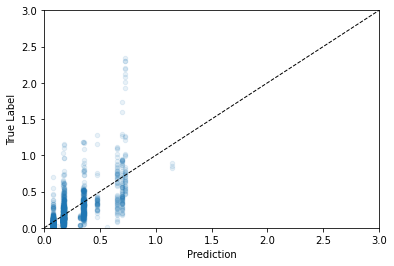

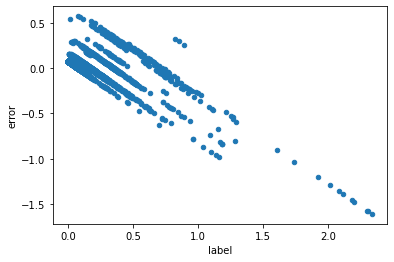

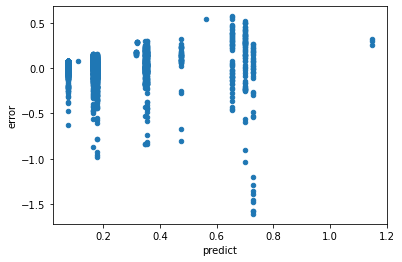

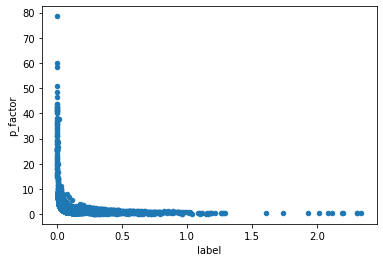

In [ ]:
non_abs_test_errors = test_predict - test_labels[label_name]
abs_test_errors = abs(non_abs_test_errors)

print(len(non_abs_test_errors))

top_test_df = pd.DataFrame.from_dict({'label': test_labels[label_name], 'predict': test_predict, 
                                      'error': non_abs_test_errors, 'p_factor': prediction_factors})

# calculate R2 score
r2 = r2_score(test_labels[label_name], test_predict)
r2 = r2_score(top_test_df['label'], top_test_df['predict'])
display("R2 Score (labels v. predict): "+str(r2))

# calculate correlation
display(top_test_df.corr())

top_test_df.plot.scatter(x='predict', y='label', alpha=0.1)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.ylabel("True Label")
plt.xlabel("Prediction")
plt.plot([0, 3], [0, 3], '--', color = 'black', linewidth = 1,)

plt.savefig('./figures/label_predict_corr.png', dpi=1000)

top_test_df.plot.scatter(x='label', y='error')
top_test_df.plot.scatter(x='predict', y='error')
top_test_df.plot.scatter(x='label', y='p_factor')


In order to compare the output of our model to random guessing, we look at the distribution of `label_name` in the test dataset.

'Label mean: 0.17289574713111358   std: 0.22519524147765269'

'Predict mean: 0.1861417316508843   std: 0.1635578488091748'

'Non Abs Error mean: 0.01324598451977057   median: 0.03628492647086487   std: 0.15723691452653749'

'Abs Error mean: 0.08871083193331569   median: 0.05452782478231402   std: 0.1304858366251239'

'Non Abs pFactor mean: 2.677143642317443   median: 1.37527181833418   std: 5.344284094768642'

'Abs pFactor mean: -0.8619360202545254   median: 0.4989576039580252   std: 5.282721194255615'

array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ])

array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ])

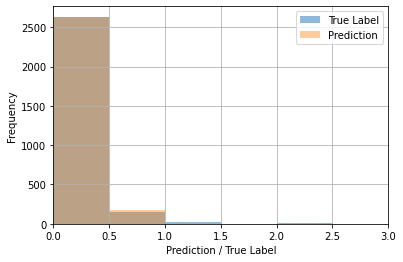

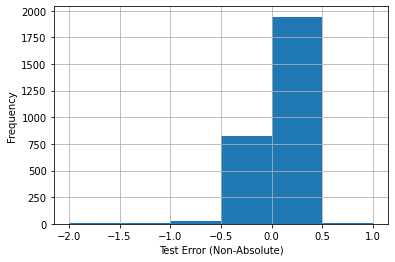

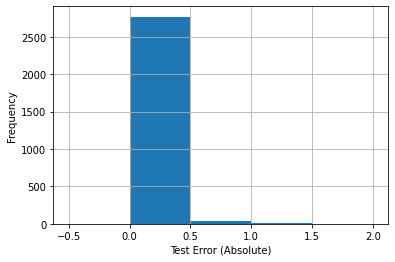

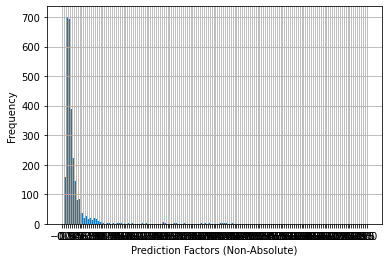

In [ ]:
label_mean = test_labels[label_name].mean()
predict_mean = test_predict.mean()
label_std = test_labels[label_name].std()
predict_std = test_predict.std()

display("Label mean: "+ str(label_mean)+ "   std: " + str(label_std))
display("Predict mean: "+ str(predict_mean)+ "   std: " + str(predict_std))

non_abs_mean = non_abs_test_errors.mean()
non_abs_median = non_abs_test_errors.median()
non_abs_std = non_abs_test_errors.std()
display("Non Abs Error mean: "+ str(non_abs_mean)+"   median: "+str(non_abs_median)+"   std: " + str(non_abs_std))
abs_mean = abs_test_errors.mean()
abs_median = abs_test_errors.median()
abs_std = abs_test_errors.std()
display("Abs Error mean: "+ str(abs_mean)+ "   median: "+str(abs_median)+ "   std: " + str(abs_std))

non_abs_p_factor_mean = pd.Series(prediction_factors).mean()
non_abs_p_factor_median = pd.Series(prediction_factors).median()
non_abs_p_factor_std = pd.Series(prediction_factors).std()
display("Non Abs pFactor mean: "+ str(non_abs_p_factor_mean)+"   median: "+str(non_abs_p_factor_median)+ \
        "   std: " + str(non_abs_p_factor_std))
abs_p_factor_mean = pd.Series(1-np.absolute(prediction_factors-1)).mean()
abs_p_factor_median = pd.Series(1-np.absolute(prediction_factors-1)).median()
abs_p_factor_std = pd.Series(1-np.absolute(prediction_factors-1)).std()
display("Abs pFactor mean: "+ str(abs_p_factor_mean)+"   median: "+str(abs_p_factor_median)+ \
        "   std: " + str(abs_p_factor_std))


binwidth = 0.5
grid_width = 3.0
#bins = np.arange((int(np.nanmin(test_labels[label_name])/binwidth)-1) * binwidth, np.nanmax(test_labels[label_name]) + binwidth, binwidth)
#xticks = np.arange((int(np.nanmin(test_labels[label_name]) / binwidth)-1) * binwidth, np.nanmax(test_labels[label_name]) + binwidth, binwidth)
bins = np.arange((int(np.nanmin(test_labels[label_name])/binwidth)-1) * binwidth, grid_width + binwidth, binwidth)
xticks = np.arange((int(np.nanmin(test_labels[label_name]) / binwidth)-1) * binwidth, grid_width + binwidth, binwidth)

display(bins)
display(xticks)

#test_labels[label_name].hist(bins=bins, alpha=0.5)
plt.xlim((0.00, grid_width))
plt.hist(test_labels[label_name], bins, alpha=0.50)
plt.xlim((0.00, grid_width))
plt.xticks(xticks)
#plt.xlabel('Test Label')
plt.ylabel('Frequency')
#plt.grid(b=True, which='major')
# plt.show()

binwidth = 0.5
#bins = np.arange((int(np.nanmin(test_predict)/binwidth)-1) * binwidth, np.nanmax(test_predict) + binwidth, binwidth)
#xticks = np.arange((int(np.nanmin(test_predict) / binwidth)-1) * binwidth, np.nanmax(test_predict) + binwidth, binwidth)
bins = np.arange((int(np.nanmin(test_predict)/binwidth)-1) * binwidth, grid_width + binwidth, binwidth)
xticks = np.arange((int(np.nanmin(test_predict) / binwidth)-1) * binwidth, grid_width + binwidth, binwidth)

#pd.DataFrame(test_predict).hist(bins=bins)
plt.hist(test_predict, bins, alpha=0.40)
plt.xticks(xticks)
plt.xlabel('Prediction / True Label')
plt.ylabel('Frequency')
plt.grid(b=True, which='major')

plt.xlim((0.00, 3.00))
plt.legend(labels=['True Label', 'Prediction'])
plt.savefig("./figures/predict_label_dist.png", dpi=1000)
plt.show()

binwidth = 0.5
bins = np.arange((int(np.nanmin(non_abs_test_errors)/binwidth)-1) * binwidth, np.nanmax(non_abs_test_errors) + binwidth, binwidth)
xticks = np.arange((int(np.nanmin(non_abs_test_errors) / binwidth)-1) * binwidth, np.nanmax(non_abs_test_errors) + binwidth, binwidth)
plt.hist(non_abs_test_errors, bins=bins)
plt.xticks(xticks)
plt.xlabel('Test Error (Non-Absolute)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

binwidth = 0.5
bins = np.arange((int(np.nanmin(abs_test_errors)/binwidth)-1) * binwidth, np.nanmax(abs_test_errors) + binwidth, binwidth)
xticks = np.arange((int(np.nanmin(abs_test_errors) / binwidth)-1) * binwidth, np.nanmax(abs_test_errors) + binwidth, binwidth)
abs_test_errors.hist(bins=bins)
plt.xticks(xticks)
plt.xlabel('Test Error (Absolute)')
plt.ylabel('Frequency')
plt.grid(b=True, which='major')
plt.show()

binwidth = 0.5
bins = np.arange((int(np.nanmin(prediction_factors)/binwidth)-1) * binwidth, np.nanmax(prediction_factors) + binwidth, binwidth)
xticks = np.arange((int(np.nanmin(prediction_factors) / binwidth)-1) * binwidth, np.nanmax(prediction_factors) + binwidth, binwidth)
pd.Series(prediction_factors).hist(bins=bins)
plt.xticks(xticks)
plt.xlabel('Prediction Factors (Non-Absolute)')
plt.ylabel('Frequency')
plt.grid(b=True, which='major')
plt.show()

In [ ]:
bin_size = 0.5
bins = np.arange(-1*bin_size, np.nanmax(top_test_df['label']), bin_size)

bin_results = {"upper_threshold": [], "mean": [], "median": [], "abs_mean": [], "abs_median": [], 
               "std": [], "abs_std": [], "count": [], "ratio": [], "mean_pfactor": [], "median_pfactor": [], 
               "abs_mean_pfactor": [], "abs_median_pfactor": []}

# for labels
for threshold in bins:
    upper_threshold = threshold + bin_size
    lower_threshold = threshold
    count = top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['error'].count()
    mean = top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['error'].mean()
    median = top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['error'].median()
    std = top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['error'].std()
    abs_mean = abs(top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['error']).mean()
    abs_median = abs(top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['error']).median()
    abs_std = abs(top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['error']).std()

    mean_pfactor = top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['p_factor'].mean()
    median_pfactor = top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['p_factor'].median()
    abs_mean_pfactor = (1-abs(top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['p_factor']-1)).mean()
    abs_median_pfactor = (1-abs(top_test_df[(top_test_df['label'] > lower_threshold) & (top_test_df['label'] <= upper_threshold)]['p_factor']-1)).median()
    
    bin_results['upper_threshold'].append(upper_threshold)
    bin_results['mean'].append(mean)
    bin_results['median'].append(median)
    bin_results['std'].append(std)
    bin_results['abs_mean'].append(abs_mean)
    bin_results['abs_median'].append(abs_median)
    bin_results['abs_std'].append(abs_std)
    bin_results['count'].append(count)
    bin_results['ratio'].append(abs_mean/upper_threshold)
    bin_results['mean_pfactor'].append(mean_pfactor)
    bin_results['median_pfactor'].append(median_pfactor)
    bin_results['abs_mean_pfactor'].append(abs_mean_pfactor)
    bin_results['abs_median_pfactor'].append(abs_median_pfactor)

bin_results_df = pd.DataFrame.from_dict(bin_results)
bin_results_df

,upper_threshold,mean,median,abs_mean,abs_median,std,abs_std,count,ratio,mean_pfactor,median_pfactor,abs_mean_pfactor,abs_median_pfactor
0,0.0,0.075871,0.075871,0.075871,0.075871,1.425807e-17,1.425807e-17,19,inf,NaN,NaN,NaN,NaN
1,0.5,0.034292,0.039119,0.070796,0.051800,9.629715e-02,7.372644e-02,2607,0.141591,2.817122,1.439533,-0.966827,0.481521
2,1.0,-0.161229,-0.168561,0.225401,0.176544,2.279583e-01,1.642852e-01,152,0.225401,0.768528,0.748482,0.660924,0.689256
3,1.5,-0.647796,-0.633673,0.647796,0.633673,2.215956e-01,2.215956e-01,22,0.431864,0.438618,0.477621,0.438618,0.477621
4,2.0,-1.044474,-1.032984,1.044474,1.032984,1.467466e-01,1.467466e-01,3,0.522237,0.406367,0.404103,0.406367,0.404103
5,2.5,-1.464315,-1.464848,1.464315,1.464848,1.161669e-01,1.161669e-01,8,0.585726,0.332994,0.332090,0.332994,0.332090


We now build the calibration plot and calculate the calibration measures.

SciPy
Slope:  0.9855900500882195  Offset:  -0.010563691490189292  R-value:  0.7159550452339124
p-value:  0.0  Standard Error:  0.01813348092787276
StatsModels


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ConfirmedGrowth   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     2954.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:42:53   Log-Likelihood:                 1212.5
No. Observations:                2811   AIC:                            -2421.
Df Residuals:                    2809   BIC:                            -2409.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0106      0.004     -2.351      0.019      -0.019      -0.002
x1             0.9856      0.018     54.352      0.000       0.950       1.021
==============================================================================
Omnibus:                     2398.738   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110383.017
Skew:                           3.800   Prob(JB):                         0.00
Kurtosis:                      32.744   Cond. No.                         6.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Standard Errors:
const    0.004493
x1       0.018133
dtype: float64
Null hypothesis (same as 0) p-values:
const    0.018792
x1       0.000000
dtype: float64


array([-0.125,  0.125,  0.375,  0.625,  0.875,  1.125,  1.375,  1.625,
        1.875,  2.125])

,bin,count,mean,std,upper,lower
0,0.00,1279,0.056844,0.056977,0.125,-0.125
1,0.25,1315,0.211546,0.163782,0.375,0.125
2,0.50,41,0.387475,0.226401,0.625,0.375
3,0.75,173,0.674394,0.451535,0.875,0.625
4,1.00,0,NaN,NaN,1.125,0.875
5,1.25,3,0.855646,0.036805,1.375,1.125
6,1.50,0,NaN,NaN,1.625,1.375
7,1.75,0,NaN,NaN,1.875,1.625
8,2.00,0,NaN,NaN,2.125,1.875
9,2.25,0,NaN,NaN,2.375,2.125


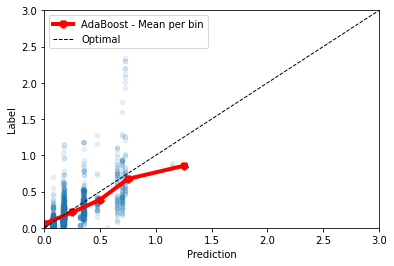

In [ ]:
# calibration measures (computed from all points)

print("SciPy")
# linear fitting (1 degree)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=test_predict, y=test_labels[label_name])
print("Slope: ", slope, " Offset: ", intercept, " R-value: ", r_value)
print("p-value: ", p_value, " Standard Error: ", std_err)

# linear fitting 
print("StatsModels")
test_predict_x = sm.add_constant(test_predict)
model = sm.OLS(endog=test_labels[label_name],exog=test_predict_x)
sm_summary = model.fit()
display(sm_summary.summary())
print("Standard Errors:")
print(sm_summary.bse)
print("Null hypothesis (same as 0) p-values:")
print(sm_summary.pvalues)

# create bins
bin_size = 0.25
bins = np.arange(-1*bin_size/2, np.nanmax(top_test_df['label']), bin_size)
calibration = {'bin': [], 'count': [], 'mean': [], 'std': [], 'upper': [], 'lower': []}

display(bins)

for threshold in bins:
  upper_threshold = threshold + bin_size
  lower_threshold = threshold
  calibration['bin'].append((upper_threshold + lower_threshold) / 2)
  calibration['count'].append(top_test_df[(top_test_df['predict'] > lower_threshold) & (top_test_df['predict'] <= upper_threshold)]['label'].count())
  calibration['mean'].append(top_test_df[(top_test_df['predict'] > lower_threshold) & (top_test_df['predict'] <= upper_threshold)]['label'].mean())
  calibration['std'].append(top_test_df[(top_test_df['predict'] > lower_threshold) & (top_test_df['predict'] <= upper_threshold)]['label'].std())
  calibration['upper'].append(upper_threshold)
  calibration['lower'].append(lower_threshold)
    
# change first bin to 0.0
calibration['bin'][0] = 0.0

calibration = pd.DataFrame.from_dict(calibration)
display(calibration)
calibration = calibration.dropna()  # remove bins which have no counts
ax = calibration.plot(x='bin', y='mean', kind='line', marker='*', color='r', markeredgewidth=5, linewidth=4)
top_test_df.plot.scatter(ax=ax, x='predict', y='label', alpha=0.1)

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.xlim([0, 3])
plt.ylim([0, 3])

# plot 45 degree line
plt.plot([0, 3], [0, 3], '--', color = 'black', linewidth = 1, )

# legend
plt.legend([top_model_name + " - Mean per bin", 'Optimal'])
plt.savefig("./figures/label_predict_corr.png", dpi=1000)


## Country Cross-Validation
We do a cross-validation by separating countries into training, validation, and test sets.

In [ ]:
from ml_pipeline import *
import random

In [ ]:
top_model_configs_cv = {}
label_predict_cv = {}     # stores labels and predictions of cross-validation samples

We separate the samples into 10 folds.  Each fold contains a 1:9 ratio between validation countries and training countries.  Feature selection based on the training data is included.

Note that because different countries have different number of samples, the ratio between validation and training samples is not necessarily 1:9.

There are 114 countries.
Num Folds: 11
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10


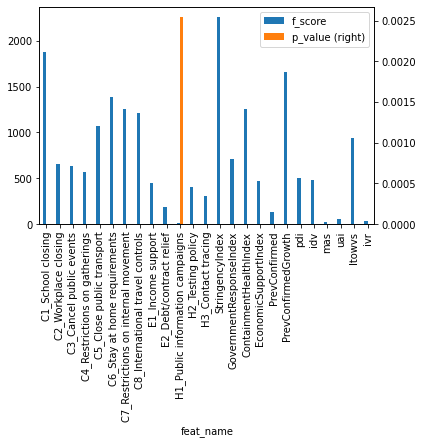

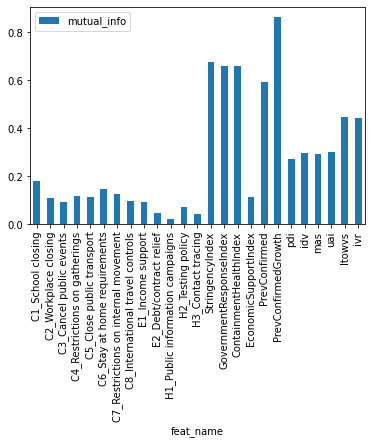

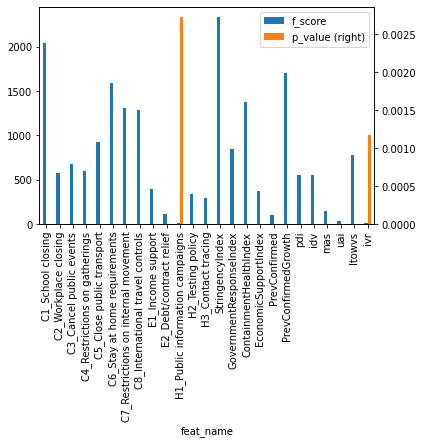

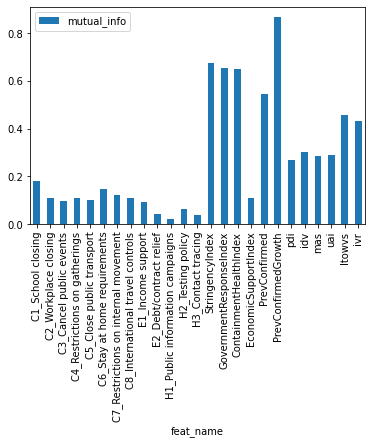

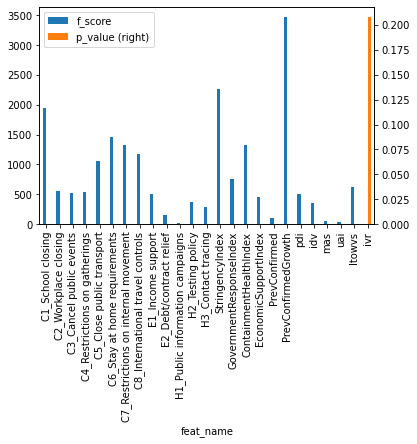

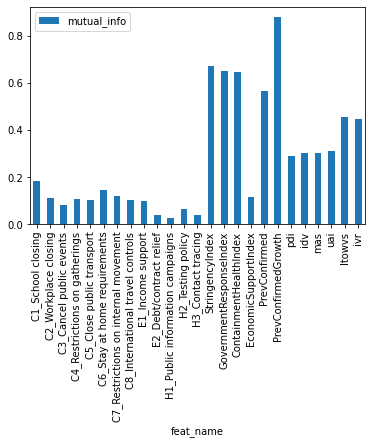

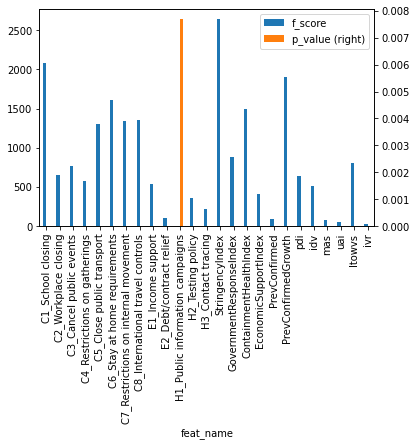

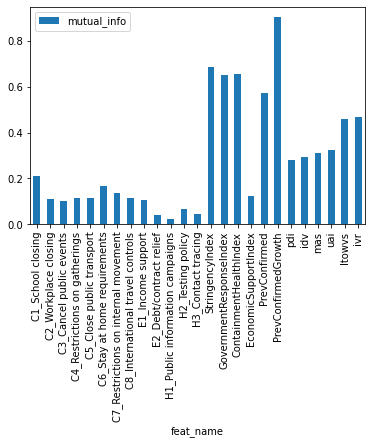

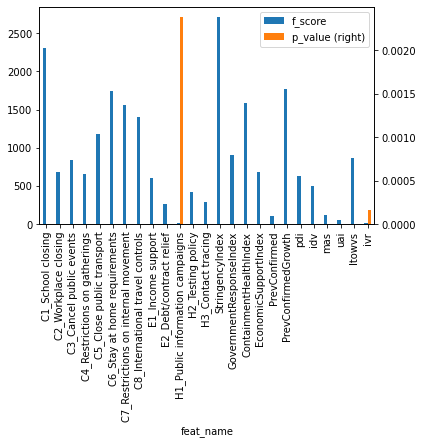

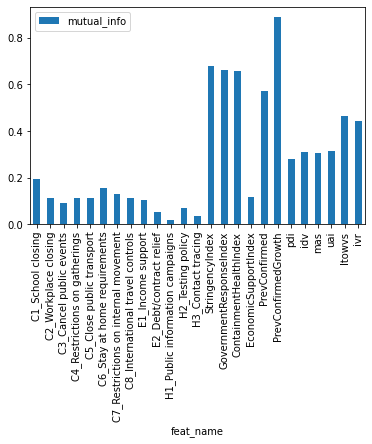

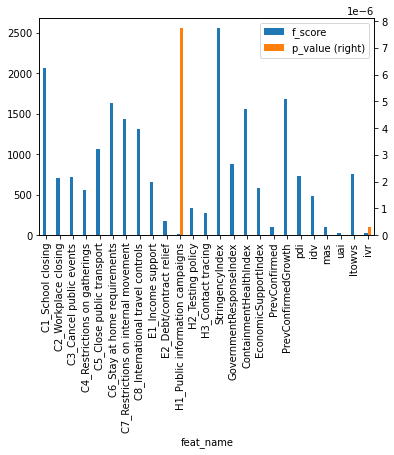

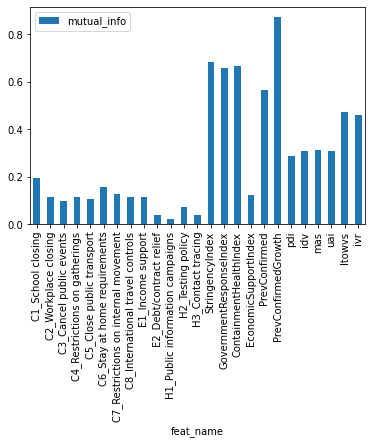

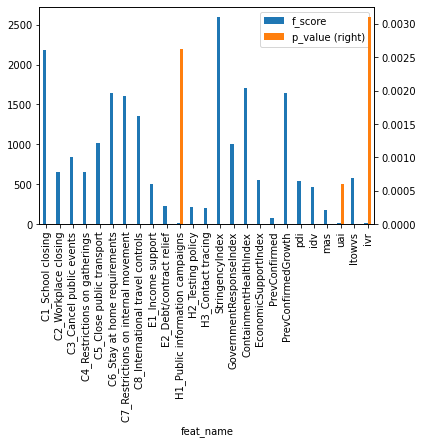

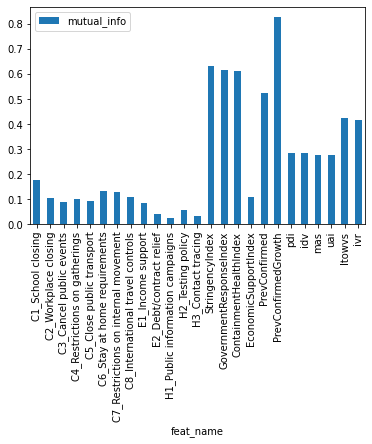

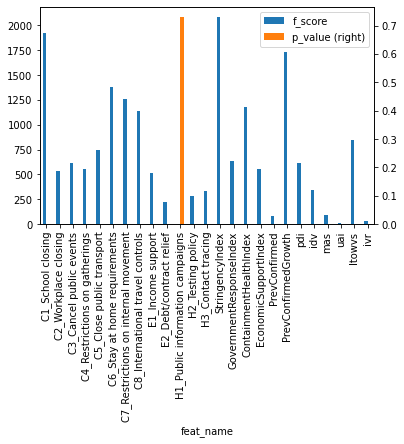

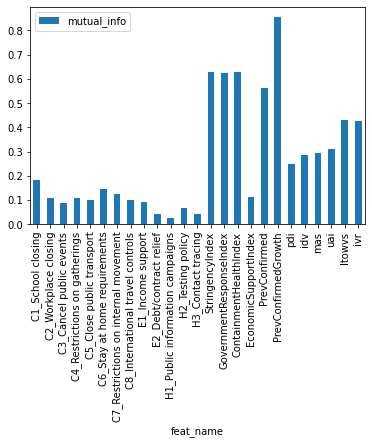

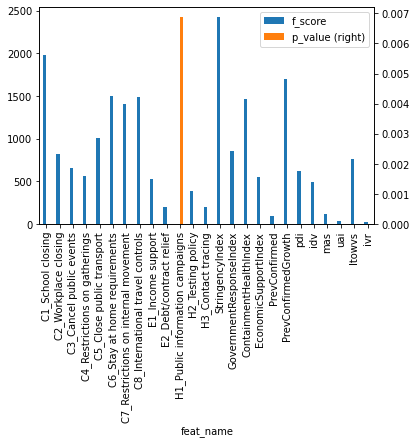

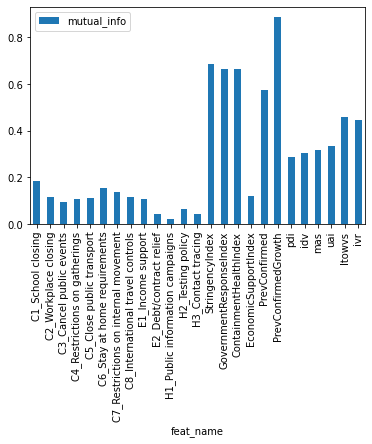

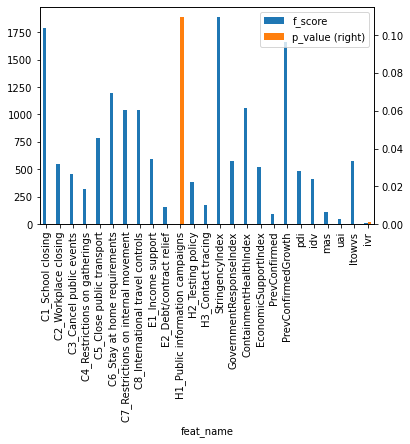

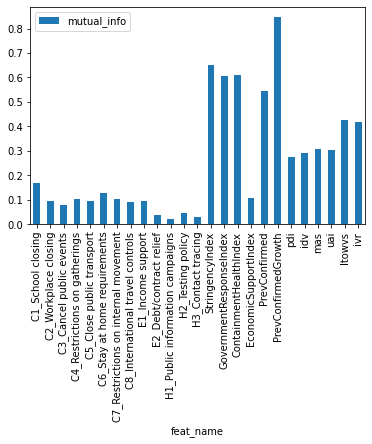

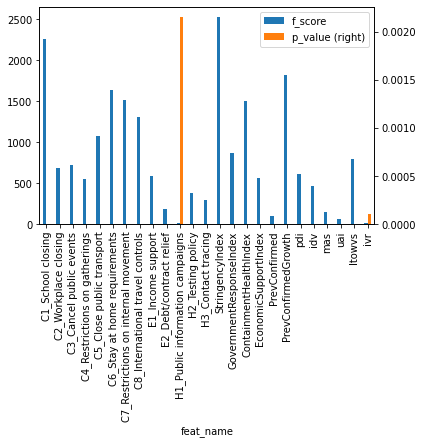

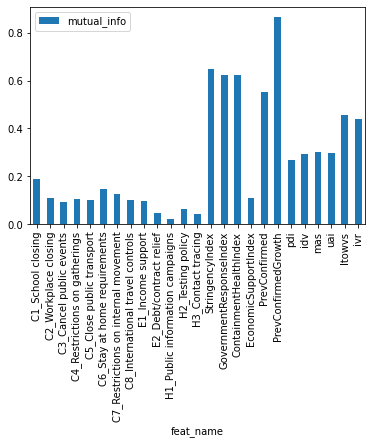

In [ ]:
features_df = stringencyidx_df.copy()

feats, labels = cross_validate_by_country(features_df, 
                                          n_splits=10, 
                                          p_value=p_threshold,
                                          mi=mi_threshold, 
                                          both_thresholds=both_thresholds, 
                                          threshold_to_use=threshold_to_use,
                                          label_name=label_name,
                                          features_to_exclude=features_to_exclude, random_seed=seed)

We now run the country cross-validation for different machine learning models.

In [ ]:
if run_models['LinearRegressionReg']:
  results, top_model_configs_cv, label_predict = ridge_regression_cv(feats=feats, 
                                                                    labels=labels, 
                                                                    seed=seed, 
                                                                    top_model_configs=top_model_configs_cv)
  label_predict_cv['LinearRegressionReg'] = label_predict
  results = pd.DataFrame.from_dict(results)
  top_model_configs_cv

In [ ]:
if run_models['DecisionTree']:
  results, top_model_configs_cv, label_predict = decision_tree_regression_cv(feats=feats, 
                                                              labels=labels, 
                                                              seed=seed, 
                                                              top_model_configs=top_model_configs_cv)

  label_predict_cv['DecisionTree'] = label_predict
  results = pd.DataFrame.from_dict(results)
  top_model_configs_cv

In [ ]:
if run_models['AdaBoost']:
  results, top_model_configs_cv, label_predict = adaboost_regression_cv(feats=feats, 
                                                              labels=labels, 
                                                              seed=seed, 
                                                              top_model_configs=top_model_configs_cv)
  label_predict_cv['AdaBoost'] = label_predict
  results = pd.DataFrame.from_dict(results)
  results

This will take several minutes.  Please be patient.
Num Estimators: 3 5 10 15 20 30 50 75 100 125 150 

In [ ]:
top_model_configs_cv

{'AdaBoost': {'estimators': 3,
  'learning_rate': 0.5,
  'loss': 'linear',
  'predict_factor': 1.30774326050295,
  'train_error': 0.16324581752730316,
  'valid_error': 0.1625455636220695}}

In [ ]:
if run_models['RandomForest']:
  results, top_model_configs_cv, label_predict = random_forest_regression_cv(feats=feats, 
                                                              labels=labels, 
                                                              seed=seed, 
                                                              top_model_configs=top_model_configs_cv)
  label_predict_cv['RandomForest'] = label_predict
  results = pd.DataFrame.from_dict(results)
  results

In [ ]:
top_model_configs_cv

{'AdaBoost': {'estimators': 3,
  'learning_rate': 0.5,
  'loss': 'linear',
  'predict_factor': 1.30774326050295,
  'train_error': 0.16324581752730316,
  'valid_error': 0.1625455636220695}}

In [ ]:
top_model_configs_cv

{'AdaBoost': {'estimators': 3,
  'learning_rate': 0.5,
  'loss': 'linear',
  'predict_factor': 1.30774326050295,
  'train_error': 0.16324581752730316,
  'valid_error': 0.1625455636220695}}

In [ ]:
if run_models['SVR']:
  results, top_model_configs_cv, label_predict = sv_regression_cv(feats=feats, 
                                                              labels=labels, 
                                                              seed=seed, 
                                                              top_model_configs=top_model_configs_cv)
  label_predict_cv['SVR'] = label_predict
  results = pd.DataFrame.from_dict(results)
  results

In [ ]:
top_model_configs_cv

{'AdaBoost': {'estimators': 3,
  'learning_rate': 0.5,
  'loss': 'linear',
  'predict_factor': 1.30774326050295,
  'train_error': 0.16324581752730316,
  'valid_error': 0.1625455636220695}}

In [ ]:
if run_models['NeuralNetwork']:
  results, top_model_configs_cv, label_predict = mlp_regression_cv(feats=feats, 
                                                              labels=labels, 
                                                              seed=seed, 
                                                              top_model_configs=top_model_configs_cv)
  label_predict_cv['NeuralNetwork'] = label_predict
  results = pd.DataFrame.from_dict(results)
  results

### Analysis

In [ ]:
top_model_configs_cv

{'AdaBoost': {'estimators': 3,
  'learning_rate': 0.5,
  'loss': 'linear',
  'predict_factor': 1.30774326050295,
  'train_error': 0.16324581752730316,
  'valid_error': 0.1625455636220695}}

We identify the best performing model by the minimum validation error.

In [ ]:
top_model_configs_cv_df = pd.DataFrame.from_dict(top_model_configs_cv)
display(top_model_configs_cv_df)

min_valid_error = None
top_model_name = None

for model in top_model_configs_cv:
    
    valid_error = top_model_configs_cv[model]['valid_error']
    
    if min_valid_error == None or min_valid_error > valid_error:
        top_model_name = model
        min_valid_error = valid_error

display("The top model is "+str(top_model_name)+" with a valid error of "+str(min_valid_error))
#top_model_name = 'SVR'

,AdaBoost
estimators,3
learning_rate,0.5
loss,linear
predict_factor,1.30774
train_error,0.163246
valid_error,0.162546


'The top model is AdaBoost with a valid error of 0.1625455636220695'

In [ ]:
model_filenames = {'LinearRegression': "./models/lr.pkl",
             'LinearRegressionReg': "./models/lr_reg.pkl",
             'DecisionTree': "./models/tree.pkl",
             'BagLinearRegression': "./models/lr_bag.pkl",
             'RandomForest': "./models/rf.pkl",
             'SVR': "./models/svr.pkl",
             'NeuralNetwork': "./models/nn.pkl",
             'AdaBoost': "./models/adaboost.pkl"
             }

clf = joblib.load(model_filenames[top_model_name])

We calculate the non-absolute error for all validation samples for the top model.

In [ ]:
label_predict_cv[top_model_name]

{'label': array([0.00891773, 0.00906553, 0.00951801, ..., 2.39130435, 2.48104693,
        2.52029312]),
 'p_factor': array([5.68538238, 5.59268653, 5.32681353, ..., 0.5772914 , 0.55641004,
        0.54774559]),
 'predict': array([0.05070068, 0.05070068, 0.05070068, ..., 1.38047943, 1.38047943,
        1.38047943])}

In [ ]:
label_predict_cv[top_model_name]['error'] = label_predict_cv[top_model_name]['label'] - label_predict_cv[top_model_name]['predict']
label_predict_cv[top_model_name]['p_factor'] = label_predict_cv[top_model_name]['p_factor']
label_predict_cv_df = pd.DataFrame.from_dict(label_predict_cv[top_model_name])
label_predict_cv_df

,label,predict,p_factor,error
0,0.008918,0.050701,5.685382,-0.041783
1,0.009066,0.050701,5.592687,-0.041635
2,0.009518,0.050701,5.326814,-0.041183
3,0.009547,0.050701,5.310530,-0.041153
4,0.010555,0.050701,4.803656,-0.040146
...,...,...,...,...
19664,2.162183,1.380479,0.638466,0.781704
19665,2.276818,1.380479,0.606320,0.896339
19666,2.391304,1.380479,0.577291,1.010825
19667,2.481047,1.380479,0.556410,1.100567


'R2 Score: 0.5824987873447918'

,label,predict,p_factor,error
label,1.000000,0.764580,-0.175866,0.603046
predict,0.764580,1.000000,-0.088505,-0.053067
p_factor,-0.175866,-0.088505,1.000000,-0.162751
error,0.603046,-0.053067,-0.162751,1.000000


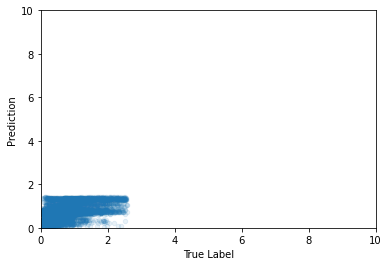

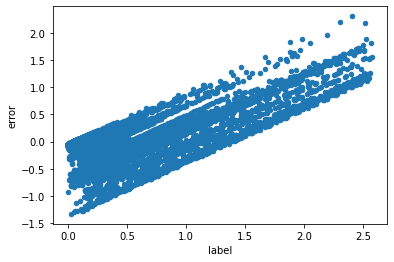

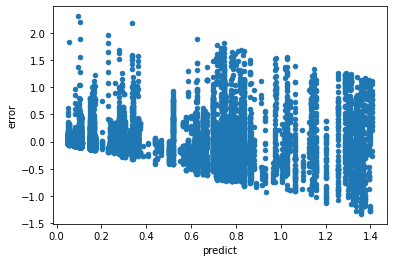

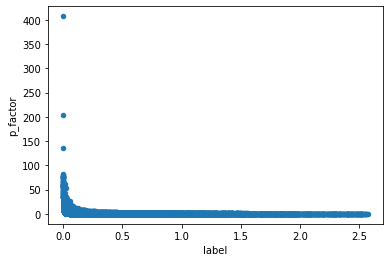

In [ ]:
# calculate R2 score
r2 = r2_score(label_predict_cv_df['label'], label_predict_cv_df['predict'])
display("R2 Score: "+str(r2))

# calculate correlation
display(label_predict_cv_df.corr()) 

label_predict_cv_df.plot.scatter(x='label', y='predict', alpha=0.1)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.savefig("./figures/label_predict_corr_cv.png", dpi=1000)

label_predict_cv_df.plot.scatter(x='label', y='error')
label_predict_cv_df.plot.scatter(x='predict', y='error')
label_predict_cv_df.plot.scatter(x='label', y='p_factor')

'Label mean: 0.34654556611693227   std: 0.44577973240365554'

'Predict mean: 0.3600024860382904   std: 0.3561032057324135'

'Non Abs Error mean: -0.013456919921310805   median: -0.031304106718976266   std: 0.28772306733716985'

'Abs Error mean: 0.16552322945396494   median: 0.06961214820286052   std: 0.23572511293656992'

'Abs pFactor mean: -0.5109269604663604   median: 0.538211082774189   std: 5.527958331431036'

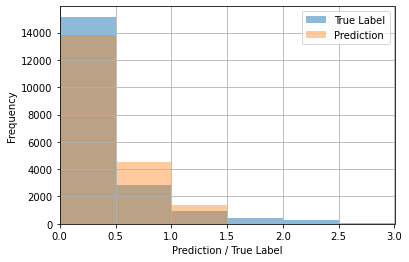

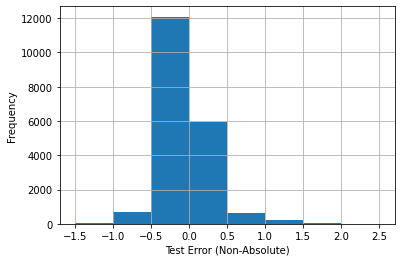

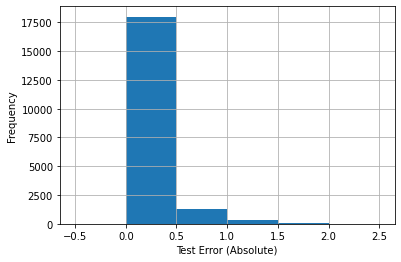

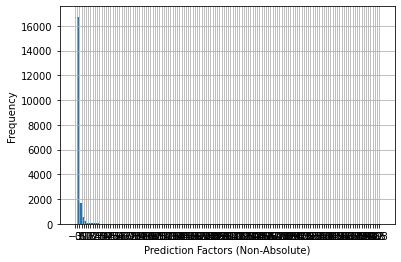

In [ ]:
test_labels = label_predict_cv_df['label']
test_predict = label_predict_cv_df['predict']
non_abs_test_errors = label_predict_cv_df['error']
abs_test_errors = abs(label_predict_cv_df['error'])
prediction_factors = label_predict_cv_df['p_factor']

label_mean = test_labels.mean()
predict_mean = test_predict.mean()
label_std = test_labels.std()
predict_std = test_predict.std()

display("Label mean: "+ str(label_mean)+ "   std: " + str(label_std))
display("Predict mean: "+ str(predict_mean)+ "   std: " + str(predict_std))

non_abs_mean = non_abs_test_errors.mean()
non_abs_median = non_abs_test_errors.median()
non_abs_std = non_abs_test_errors.std()
display("Non Abs Error mean: "+ str(non_abs_mean)+"   median: "+str(non_abs_median)+"   std: " + str(non_abs_std))
abs_mean = abs_test_errors.mean()
abs_median = abs_test_errors.median()
abs_std = abs_test_errors.std()
display("Abs Error mean: "+ str(abs_mean)+ "   median: "+str(abs_median)+ "   std: " + str(abs_std))

abs_p_factor_mean = pd.Series(1-np.absolute(prediction_factors-1)).mean()
abs_p_factor_median = pd.Series(1-np.absolute(prediction_factors-1)).median()
abs_p_factor_std = pd.Series(1-np.absolute(prediction_factors-1)).std()
display("Abs pFactor mean: "+ str(abs_p_factor_mean)+"   median: "+str(abs_p_factor_median)+ \
        "   std: " + str(abs_p_factor_std))


binwidth = 0.5
bins = np.arange((int(np.nanmin(test_labels)/binwidth)-1) * binwidth, np.nanmax(test_labels) + binwidth, binwidth)
xticks = np.arange((int(np.nanmin(test_labels) / binwidth)-1) * binwidth, np.nanmax(test_labels) + binwidth, binwidth)
#test_labels.hist(bins=bins)
plt.hist(test_labels, bins, alpha=0.5)
plt.xticks(xticks)
#plt.xlabel('Test Label')
plt.ylabel('Frequency')
plt.grid(b=True, which='major')
#plt.show()

binwidth = 0.5
bins = np.arange((int(np.nanmin(test_predict)/binwidth)-1) * binwidth, np.nanmax(test_predict) + binwidth, binwidth)
#xticks = np.arange((int(np.nanmin(test_predict) / binwidth)-1) * binwidth, np.nanmax(test_predict) + binwidth, binwidth)
#pd.DataFrame(test_predict).hist(bins=bins)
plt.hist(test_predict, bins, alpha=0.4)
plt.xticks(xticks)
#plt.xlabel('Test Predict')
plt.ylabel('Frequency')
plt.grid(b=True, which='major')

plt.xlim((0, np.max(xticks)))
plt.xlabel("Prediction / True Label")
plt.legend(labels=['True Label', 'Prediction'])
plt.savefig("./figures/predict_label_dist_cv.png", dpi=1000)
plt.show()

binwidth = 0.5
bins = np.arange((int(np.nanmin(non_abs_test_errors)/binwidth)-1) * binwidth, np.nanmax(non_abs_test_errors) + binwidth, binwidth)
xticks = np.arange((int(np.nanmin(non_abs_test_errors) / binwidth)-1) * binwidth, np.nanmax(non_abs_test_errors) + binwidth, binwidth)
plt.hist(non_abs_test_errors, bins=bins)
plt.xticks(xticks)
plt.xlabel('Test Error (Non-Absolute)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

binwidth = 0.5
bins = np.arange((int(np.nanmin(abs_test_errors)/binwidth)-1) * binwidth, np.nanmax(abs_test_errors) + binwidth, binwidth)
xticks = np.arange((int(np.nanmin(abs_test_errors)/binwidth)-1) * binwidth, np.nanmax(abs_test_errors) + binwidth, binwidth)
abs_test_errors.hist(bins=bins)
plt.xticks(xticks)
plt.xlabel('Test Error (Absolute)')
plt.ylabel('Frequency')
plt.grid(b=True, which='major')
plt.show()

binwidth = 3
bins = np.arange((int(np.nanmin(prediction_factors)/binwidth)-1) * binwidth, np.nanmax(prediction_factors) + binwidth, binwidth)
xticks = np.arange((int(np.nanmin(prediction_factors)/binwidth)-1) * binwidth, np.nanmax(prediction_factors) + binwidth, binwidth)
pd.Series(prediction_factors).hist(bins=bins)
plt.xticks(xticks)
plt.xlabel('Prediction Factors (Non-Absolute)')
plt.ylabel('Frequency')
plt.grid(b=True, which='major')
plt.show()

In [ ]:
bin_size = 0.5
bins = np.arange(-1*bin_size, np.nanmax(test_labels), bin_size)

bin_results = {"upper_threshold": [], "mean": [], "median": [], "abs_mean": [], 
               "abs_median": [], "std": [], "abs_std": [], "count": [], "ratio": [],
               "mean_pfactor": [], "median_pfactor": [], 
               "abs_mean_pfactor": [], "abs_median_pfactor": []}

# for labels
for threshold in bins:
    upper_threshold = threshold + bin_size
    lower_threshold = threshold
    count = label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['error'].count()
    mean = label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['error'].mean()
    median = label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['error'].median()
    std = label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['error'].std()
    abs_mean = abs(label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['error']).mean()
    abs_median = abs(label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['error']).median()
    abs_std = abs(label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['error']).std()


    mean_pfactor = label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['p_factor'].mean()
    median_pfactor = label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['p_factor'].median()
    abs_mean_pfactor = (1-abs(label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['p_factor']-1)).mean()
    abs_median_pfactor = (1-abs(label_predict_cv_df[(label_predict_cv_df['label'] > lower_threshold) & (label_predict_cv_df['label'] <= upper_threshold)]['p_factor']-1)).median()
    

    bin_results['upper_threshold'].append(upper_threshold)
    bin_results['mean'].append(mean)
    bin_results['median'].append(median)
    bin_results['abs_mean'].append(abs_mean)
    bin_results['abs_median'].append(abs_median)
    bin_results['std'].append(std)
    bin_results['abs_std'].append(abs_std)
    bin_results['count'].append(count)
    bin_results['ratio'].append(abs_mean/upper_threshold)
    bin_results['mean_pfactor'].append(mean_pfactor)
    bin_results['median_pfactor'].append(median_pfactor)
    bin_results['abs_mean_pfactor'].append(abs_mean_pfactor)
    bin_results['abs_median_pfactor'].append(abs_median_pfactor)

bin_results_df = pd.DataFrame.from_dict(bin_results)
bin_results_df

,upper_threshold,mean,median,abs_mean,abs_median,std,abs_std,count,ratio,mean_pfactor,median_pfactor,abs_mean_pfactor,abs_median_pfactor
0,0.0,-0.059879,-0.051623,0.059879,0.051623,0.082568,0.082568,114,inf,NaN,NaN,NaN,NaN
1,0.5,-0.075916,-0.036472,0.110312,0.053199,0.177347,0.158259,15056,0.220624,2.711896,1.506388,-0.863346,0.418738
2,1.0,-0.012131,-0.017002,0.216072,0.171880,0.280939,0.179917,2815,0.216072,1.034027,1.023933,0.685086,0.762497
3,1.5,0.300182,0.313487,0.363163,0.319972,0.320381,0.246622,960,0.242109,0.758408,0.720409,0.701335,0.710815
4,2.0,0.702838,0.677373,0.702838,0.677373,0.344080,0.344080,451,0.351419,0.600203,0.616219,0.600203,0.616219
5,2.5,1.126400,1.094470,1.126400,1.094470,0.299063,0.299063,246,0.450560,0.497992,0.538805,0.497992,0.538805
6,3.0,1.371754,1.233321,1.371754,1.233321,0.274312,0.274312,27,0.457251,0.457646,0.511967,0.457646,0.511967


We now build the calibration plot and calculate the calibration measures.

Scipy
Slope:  0.9571227416801394  Offset:  0.001978999668342918  R-value:  0.7645804683714778
p-value:  0.0  Standard Error:  0.005753304452314177
StatsModels
StatsModels


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                 2.768e+04
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:57:28   Log-Likelihood:                -3378.1
No. Observations:               19669   AIC:                             6760.
Df Residuals:                   19667   BIC:                             6776.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.679      0.497      -0.004       0.008
predict        0.9571      0.006    166.361      0.000       0.946       0.968
==============================================================================
Omnibus:                     7406.739   Durbin-Watson:                   0.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63094.478
Skew:                           1.577   Prob(JB):                         0.00
Kurtosis:                      11.188   Cond. No.                         3.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Standard Errors:
const      0.002913
predict    0.005753
dtype: float64
Null hypothesis (same as 0) p-values:
const      0.496952
predict    0.000000
dtype: float64


,bin,count,mean,std
0,0.00,7424,0.065145,0.093315
1,0.25,6337,0.249980,0.208497
2,0.50,722,0.511761,0.284668
3,0.75,3700,0.703555,0.438209
4,1.00,383,0.999327,0.595516
5,1.25,971,1.231627,0.616152
6,1.50,132,1.493529,0.677402
7,1.75,0,NaN,NaN
8,2.00,0,NaN,NaN
9,2.25,0,NaN,NaN


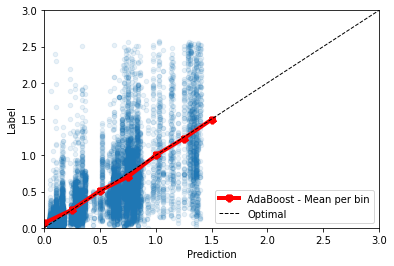

In [ ]:
# calibration measures (computed from all points)

# linear fitting (1 degree)
print("Scipy")
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=test_predict, y=test_labels)
print("Slope: ", slope, " Offset: ", intercept, " R-value: ", r_value)
print("p-value: ", p_value, " Standard Error: ", std_err)

print("StatsModels")
# linear fitting 
print("StatsModels")
test_predict_x = sm.add_constant(test_predict)
model = sm.OLS(endog=test_labels,exog=test_predict_x)
sm_summary = model.fit()
display(sm_summary.summary())
print("Standard Errors:") 
print(sm_summary.bse)
print("Null hypothesis (same as 0) p-values:")
print(sm_summary.pvalues)

# create bins
bin_size = 0.25
bins = np.arange(-1*bin_size/2, np.nanmax(label_predict_cv_df['label']), bin_size)
calibration = {'bin': [], 'count': [], 'mean': [], 'std': []}

for threshold in bins:
  upper_threshold = threshold + bin_size
  lower_threshold = threshold
  calibration['bin'].append((upper_threshold + lower_threshold) / 2)
  calibration['count'].append(label_predict_cv_df[(label_predict_cv_df['predict'] > lower_threshold) & (label_predict_cv_df['predict'] <= upper_threshold)]['label'].count())
  calibration['mean'].append(label_predict_cv_df[(label_predict_cv_df['predict'] > lower_threshold) & (label_predict_cv_df['predict'] <= upper_threshold)]['label'].mean())
  calibration['std'].append(label_predict_cv_df[(label_predict_cv_df['predict'] > lower_threshold) & (label_predict_cv_df['predict'] <= upper_threshold)]['label'].std())

# change first bin to 0.0
calibration['bin'][0] = 0.0

calibration = pd.DataFrame.from_dict(calibration)
display(calibration)
ax = calibration.plot(x='bin', y='mean', kind='line', marker='*', color='r', markeredgewidth=5, linewidth=4)
label_predict_cv_df.plot.scatter(ax=ax, x='predict', y='label', alpha=0.1)

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.xlim([0, 3])
plt.ylim([0, 3])

# plot 45 degree line
plt.plot([0, 6], [0, 6], '--', color = 'black', linewidth = 1, )

# legend
plt.legend([top_model_name + " - Mean per bin", 'Optimal'])
plt.savefig("./figures/label_predict_corr_cv.png", dpi=1000)
